# Ventes en magasin - Prévision de séries temporelles multiples
***

Cet article porte sur une [compétition Kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview) dont le sujet est la prévision de séries temporelles pour les ventes en magasin. Les données proviennent d'une entreprise équatorienne connue sous le nom de **Corporación Favorita** qui est un grand détaillant en alimentation.

Il y a **54 magasins** et **33 familles de produits** dans les données. Les séries temporelles commencent le **2013-01-01** et se termine le **2017-08-31**. Cependant, Kaggle nous donne deux jeux de données séparées dont le Train et le Test. Les dates dans les données de test correspondent aux **15 jours** suivant la dernière date dans les données d'entraînement.

***Notre mission principale dans cette compétition est de prédire les ventes pour chaque famille de produits combinée avec chaque magasin.***

Nous étudierons pas à pas 6 jeux de données :
1. *train.csv*
2. *test.csv*
3. *store.csv*
4. *transactions.csv*
5. *holidays_events.csv*
6. *oil.csv*

- Les données de **<code>train.csv</code>** contiennent les séries temporelles des ventes de chaque famille de produits dans chaque magasin. La colonne des ventes donne le total des ventes pour une famille de produits dans un magasin particulier à une date donnée. Les valeurs décimales sont possibles puisque les produits peuvent être vendus en unités fractionnaires. La colonne `onpromotion` donne le nombre total d'articles d'une famille mis en promotion dans un magasin à une date donnée.

- Les données de **<code>store.csv</code>** donnent des informations sur les magasins tels que la ville, la région, le type et le cluster.

- Les données de **<code>transactions.csv</code>** indiquent combien de personnes ont effectué des achats ou combien de factures ont été créées en une journée.

- Les données de **<code>holidays_events.csv</code>** donnent des informations sur les vacances et événements dans le pays, région ou ville.

- Les données de **<code>oil.csv</code>** sont relatives au pétrole. L'Équateur est un pays dépendant du pétrole et sa santé économique est très vulnérable aux changements des prix du pétrole. C'est pourquoi, cela nous aidera à comprendre quelles familles de produits sont affectées de manière positive ou négative par le prix du pétrole.

- La métrique d'évaluation pour cette compétition est la racine carrée de l'erreur logarithmique quadratique moyenne (RMSLE) dont la formule est :
$$
\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}
$$

## 1. Packages et configurations

In [1]:
# %reset
!pip install --upgrade -q seaborn
!pip install --upgrade -q  plotly
!pip install --upgrade -q statsmodels
!pip install --upgrade -q  xgboost

# BASE
# ------------------------------------------------------
import numpy as np
import os
import gc
import pandas as pd
import warnings

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# MODELING
# ------------------------------------------------------
from sklearn.linear_model import LinearRegression, Ridge, MultiTaskLassoCV, RidgeCV, MultiTaskElasticNetCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_log_error

from xgboost import XGBRegressor

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

# Setup files
from pathlib import Path

# comp_dir = Path('../input/store-sales-time-series-forecasting') # Dossier des données sur un Notebook Kaggle de soumission
comp_dir = Path('workspace')

# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('expand_frame_repr', False)
# os.chdir('...')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')
gc.enable()

COLORS = list(sns.color_palette())

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def print_rmsle(yy_train, yy_pred, yy_test, yy_test_pred):
    rmsle_train = mean_squared_log_error(yy_train, yy_pred) ** 0.5
    rmsle_valid = mean_squared_log_error(yy_test, yy_test_pred) ** 0.5
    print(f'Training RMSLE: {rmsle_train:.5f}')
    print(f'Validation RMSLE: {rmsle_valid:.5f}')

## 2. Importation des données

### 2.1. Données d'entrainement

In [3]:
train = pd.read_csv(
    comp_dir / 'train.csv',
    dtype={
        'store_nbr': 'string',
        'family': 'string',
        'sales': 'float',
        'onpromotion': 'int',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
train['date'] = train.date.dt.to_period('D')
train.head()

id        date store_nbr      family  sales  onpromotion
0   0  2013-01-01         1  AUTOMOTIVE   0.00            0
1   1  2013-01-01         1   BABY CARE   0.00            0
2   2  2013-01-01         1      BEAUTY   0.00            0
3   3  2013-01-01         1   BEVERAGES   0.00            0
4   4  2013-01-01         1       BOOKS   0.00            0

In [4]:
train.shape

(3000888, 6)

In [5]:
train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Le jeu de données d'entrainement ne contient aucune valeur nulle les variables ayant chacune un type fixé.

### 2.2. Données de test

In [6]:
test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'string',
        'family': 'string',
        'onpromotion': 'int',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
print(test.shape)

(28512, 5)


In [7]:
test.head()

id        date store_nbr      family  onpromotion
0  3000888  2017-08-16         1  AUTOMOTIVE            0
1  3000889  2017-08-16         1   BABY CARE            0
2  3000890  2017-08-16         1      BEAUTY            2
3  3000891  2017-08-16         1   BEVERAGES           20
4  3000892  2017-08-16         1       BOOKS            0

In [8]:
print(test.date.min())
print(test.date.max())

2017-08-16
2017-08-31


In [9]:
test_time_steps = (test.date.max() - test.date.min()).delta.days + 1
ts_number = train.family.unique().shape[0] * train.store_nbr.unique().shape[0]
print(f"Taille de la plage de jour dans le dataframe de test : {test_time_steps}")
print(f"Nombre de combinaison de magasin et de produits : {ts_number}")
print(f"Nombre de ventes de chaque famille combiné à chaque magasin pour tous les jours de la plage de Test : "
      f"{test_time_steps * ts_number}")
print(f"Taille de l'ensemble de test : {len(test)}")

Taille de la plage de jour dans le dataframe de test : 16
Nombre de combinaison de magasin et de produits : 1782
Nombre de ventes de chaque famille combiné à chaque magasin pour tous les jours de la plage de Test : 28512
Taille de l'ensemble de test : 28512


Ainsi, l'ensemble de test représente les jours de ventes de chaque famille de produits combinée à chaque magasin pour 16 jours. Ces jours sont du 2017-08-16 au 2017-08-31. Étant donné que nous devons prédire les ventes de chaque famille dans chaque magasin, nous avons 1782 series temporelles à prédire au total.

Fusionnons les données de Train et de Test pour appliquer une selection de variable.

In [10]:
train_test = pd.concat([train, test])
train_test.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
dtype: int64

### 2.3. Données des magasins

In [11]:
stores = pd.read_csv(
    comp_dir / 'stores.csv',
    dtype={
        'store_nbr': 'string',
        'city': 'string',
        'state': 'string',
        'type': 'string',
        'cluster': 'string',
    }
)
stores.head()

store_nbr           city                           state type cluster
0         1          Quito                       Pichincha    D      13
1         2          Quito                       Pichincha    D      13
2         3          Quito                       Pichincha    D       8
3         4          Quito                       Pichincha    D       9
4         5  Santo Domingo  Santo Domingo de los Tsachilas    D       4

In [12]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

### 2.4. Données sur les transactions

In [13]:
transactions = pd.read_csv(
    comp_dir / 'transactions.csv',
    dtype={
        'store_nbr': 'string',
        'transactions': 'int',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
transactions['date'] = transactions.date.dt.to_period('D')
transactions.head()

date store_nbr  transactions
0  2013-01-01        25           770
1  2013-01-02         1          2111
2  2013-01-02         2          2358
3  2013-01-02         3          3487
4  2013-01-02         4          1922

In [14]:
print(transactions.shape)
transactions.isna().sum()

(83488, 3)


date            0
store_nbr       0
transactions    0
dtype: int64

### 2.5. Données des vacances et événements

In [15]:
holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'string',
        'locale': 'string',
        'locale_name': 'string',
        'description': 'string',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

holidays_events['date'] = holidays_events.date.dt.to_period('D')
holidays_events.head()

date     type    locale locale_name                    description  transferred
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta        False
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi        False
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca        False
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad        False
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba        False

### 2.6. Données sur le prix de pétrole

In [16]:
oil = pd.read_csv(
    comp_dir / 'oil.csv',
    dtype={
        'sales': 'float',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
oil['date'] = oil.date.dt.to_period('D')
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

## 3. Analyse des series temporelles

### 3.1. Valeurs aberrantes

Les boites à moustache nous indique la présence de certaines valeurs aberrantes sur les données des ventes. Ces valeurs pourraient être expliquées par des événements particuliers.

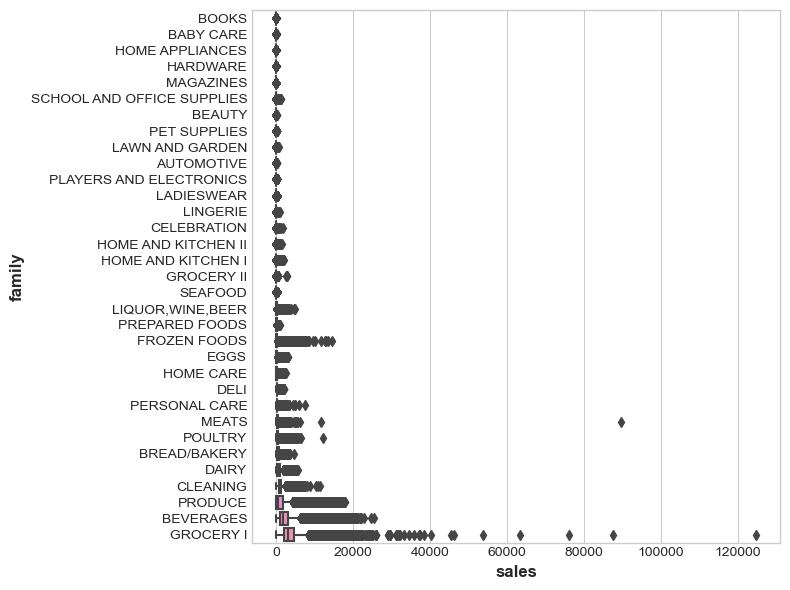

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=train, x='sales', y='family',
            order=train.groupby('family').sales.mean().sort_values(ascending=True).index)

Les boites à moustache nous indique la présence de certaines valeurs aberrantes sur les données des ventes. Ces valeurs pourraient être expliquées par des événements particuliers. Nous pouvons afficher les boites à moustaches sans les valeurs aberrantes.

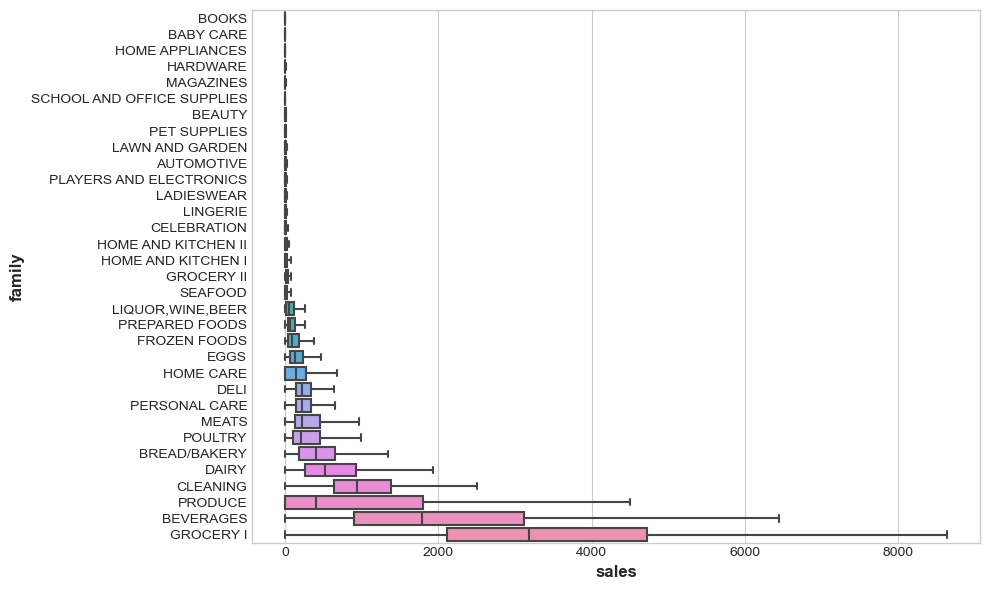

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='sales', y='family',
            order=train.groupby('family').sales.mean().sort_values(ascending=True).index,
            showfliers=False)

Affichons les données aberrantes des ventes correspondantes à des événements particuliers.

In [19]:
print(f"Sales max during events : {train.loc[train.date.isin(holidays_events.date)].sales.max()}")
print(f"Sales min during events : {train.loc[train.date.isin(holidays_events.date)].sales.min()}")

Sales max during events : 124717.0
Sales min during events : 0.0


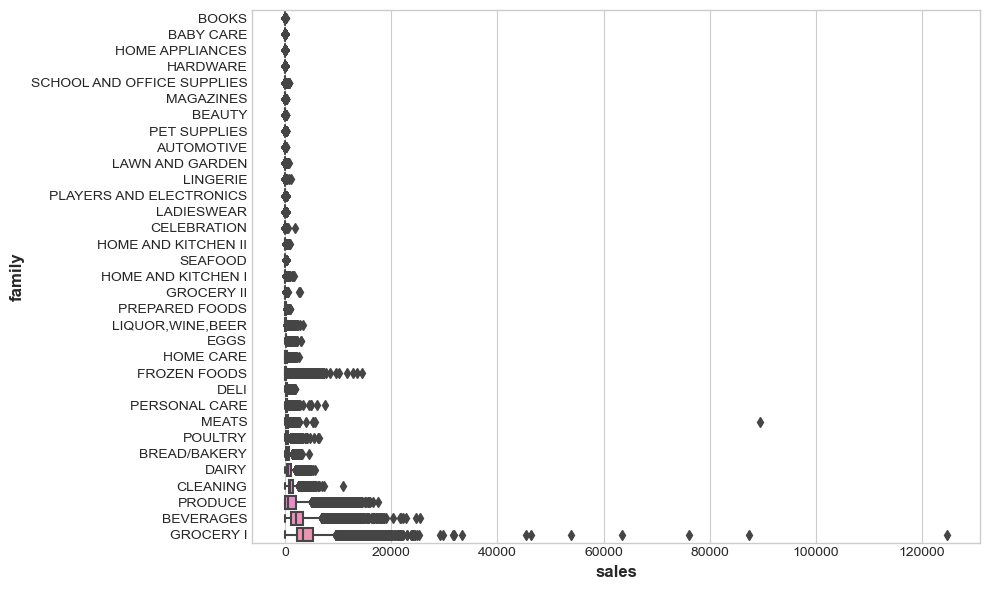

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=train.loc[train.date.isin(holidays_events.date)], x='sales', y='family',
    order=train.loc[train.date.isin(holidays_events.date)].groupby('family').sales.mean().sort_values(
        ascending=True).index
)

Les valeurs extremes des ventes lors des vacances et événements sont similaires aux valeurs extremes des ventes globales. Ce qui explique les valeurs aberrantes.

### 3.2. Prédiction à zero

Certains magasins ne vendent pas certaines familles de produits. Dans le code suivant, nous pouvons voir les produits qui ne sont pas vendus dans certains magasins. Il n'est pas difficile de les prévoir pour les 15 prochains jours. Leurs prévisions doivent être 0 pour les 15 prochains jours.

Nous allons les supprimer et créer un nouveau dataframe pour les familles de produits qui ne se vendent jamais. Ensuite, lorsque nous en serons à la partie soumission, nous combinerons ce dataframe avec nos prédictions.

In [21]:
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family", "store_nbr"])
c = c[c.sales == 0]
c

store_nbr           family  sales
1            1        BABY CARE   0.00
133         13        BABY CARE   0.00
496         23        BABY CARE   0.00
1255        44        BABY CARE   0.00
1288        45        BABY CARE   0.00
1321        46        BABY CARE   0.00
1354        47        BABY CARE   0.00
1387        48        BABY CARE   0.00
1420        49        BABY CARE   0.00
1486        50        BABY CARE   0.00
1519        51        BABY CARE   0.00
1552        52        BABY CARE   0.00
37          10            BOOKS   0.00
70          11            BOOKS   0.00
103         12            BOOKS   0.00
136         13            BOOKS   0.00
169         14            BOOKS   0.00
202         15            BOOKS   0.00
235         16            BOOKS   0.00
268         17            BOOKS   0.00
301         18            BOOKS   0.00
334         19            BOOKS   0.00
400         20            BOOKS   0.00
433         21            BOOKS   0.00
466         22            BOOKS   0.00
664         28            BOOKS   0.00
697         29            BOOKS   0.00
763         30            BOOKS   0.00
796         31            BOOKS   0.00
829         32            BOOKS   0.00
862         33            BOOKS   0.00
895         34            BOOKS   0.00
928         35            BOOKS   0.00
961         36            BOOKS   0.00
1060        39            BOOKS   0.00
1126        40            BOOKS   0.00
1225        43            BOOKS   0.00
1555        52            BOOKS   0.00
1621        54            BOOKS   0.00
1753         9            BOOKS   0.00
250         16       LADIESWEAR   0.00
580         25       LADIESWEAR   0.00
679         28       LADIESWEAR   0.00
712         29       LADIESWEAR   0.00
844         32       LADIESWEAR   0.00
877         33       LADIESWEAR   0.00
943         35       LADIESWEAR   0.00
1141        40       LADIESWEAR   0.00
1240        43       LADIESWEAR   0.00
1636        54       LADIESWEAR   0.00
185         14  LAWN AND GARDEN   0.00
779         30  LAWN AND GARDEN   0.00
1637        54  LAWN AND GARDEN   0.00

In [22]:
print(train.shape)
# Anti Join
outer_join = train.merge(c[c.sales == 0].drop("sales", axis=1), how='outer', indicator=True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis=1)
del outer_join
gc.collect()
train.shape

(3000888, 6)


(2911636, 6)

In [23]:
zero_prediction = []
for i in range(0, len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date": pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr": c.store_nbr.iloc[i],
            "family": c.family.iloc[i],
            "sales": 0
        })
    )
zero_prediction = pd.concat(zero_prediction)
zero_prediction['date'] = zero_prediction.date.dt.to_period('D')
del c, i
gc.collect()
zero_prediction

date store_nbr           family  sales
0   2017-08-16         1        BABY CARE      0
1   2017-08-17         1        BABY CARE      0
2   2017-08-18         1        BABY CARE      0
3   2017-08-19         1        BABY CARE      0
4   2017-08-20         1        BABY CARE      0
..         ...       ...              ...    ...
11  2017-08-27        54  LAWN AND GARDEN      0
12  2017-08-28        54  LAWN AND GARDEN      0
13  2017-08-29        54  LAWN AND GARDEN      0
14  2017-08-30        54  LAWN AND GARDEN      0
15  2017-08-31        54  LAWN AND GARDEN      0

[848 rows x 4 columns]

In [24]:
train_test = pd.concat([train, test])
train_test.isna().sum()

id                 0
date               0
store_nbr          0
family             0
sales          28512
onpromotion        0
dtype: int64

### 3.3. Variables sur les vacances, événements et les magasins


In [25]:
holidays_events.head()

date     type    locale locale_name                    description  transferred
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta        False
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi        False
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca        False
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad        False
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba        False

In [26]:
print(holidays_events.shape)
holidays_events = holidays_events[holidays_events.date.isin(train_test.date)]
holidays_events.shape

(350, 6)


(283, 6)

Nous retirons des jours de vacances et événements ceux qui sont transférés car ils sont similaires aux jours normaux.

In [27]:
print(holidays_events.shape)
holidays_events = holidays_events[holidays_events.transferred.eq(False)].reset_index(drop=True)
holidays_events = holidays_events.drop(['transferred'], axis=1)
holidays_events.shape

(283, 6)


(274, 5)

In [28]:
holidays_events["holiday"] = np.where(holidays_events["locale"] == "National", True, False)
holidays_events["local_holiday"] = np.where(holidays_events["locale"] == "Local", True, False)
holidays_events["regional_holiday"] = np.where(holidays_events["locale"] == "Regional", True, False)

holidays_events["holiday"] = holidays_events["holiday"].astype('bool')
holidays_events["local_holiday"] = holidays_events["local_holiday"].astype('bool')
holidays_events["regional_holiday"] = holidays_events["regional_holiday"].astype('bool')

holidays_events = holidays_events.rename(columns={"type": "holiday_type"})

holidays_events = holidays_events.drop(['locale', 'description'], axis=1)
holidays_events.head()

date holiday_type locale_name  holiday  local_holiday  regional_holiday
0  2013-01-01      Holiday     Ecuador     True          False             False
1  2013-01-05     Work Day     Ecuador     True          False             False
2  2013-01-12     Work Day     Ecuador     True          False             False
3  2013-02-11      Holiday     Ecuador     True          False             False
4  2013-02-12      Holiday     Ecuador     True          False             False

In [29]:
data = pd.merge(train_test, holidays_events.loc[holidays_events.date.isin(train_test.date)], how="left", on="date")
data.drop_duplicates(subset=['id', 'store_nbr', 'family', 'sales', 'onpromotion'], inplace=True)

data = pd.merge(data, stores, how="left", on="store_nbr")
data.head()

id        date store_nbr      family  sales  onpromotion holiday_type locale_name holiday local_holiday regional_holiday   city      state type cluster
0     0  2013-01-01         1  AUTOMOTIVE   0.00            0      Holiday     Ecuador    True         False            False  Quito  Pichincha    D      13
1  1782  2013-01-02         1  AUTOMOTIVE   2.00            0         <NA>        <NA>     NaN           NaN              NaN  Quito  Pichincha    D      13
2  3564  2013-01-03         1  AUTOMOTIVE   3.00            0         <NA>        <NA>     NaN           NaN              NaN  Quito  Pichincha    D      13
3  5346  2013-01-04         1  AUTOMOTIVE   3.00            0         <NA>        <NA>     NaN           NaN              NaN  Quito  Pichincha    D      13
4  7128  2013-01-05         1  AUTOMOTIVE   5.00            0     Work Day     Ecuador    True         False            False  Quito  Pichincha    D      13

In [30]:
print(data.shape)
print(train_test.shape)
data.isna().sum()

(2940148, 15)
(2940148, 6)


id                        0
date                      0
store_nbr                 0
family                    0
sales                 28512
onpromotion               0
holiday_type        2518219
locale_name         2518219
holiday             2518219
local_holiday       2518219
regional_holiday    2518219
city                      0
state                     0
type                      0
cluster                   0
dtype: int64

In [31]:
data["holiday"] = data["holiday"].fillna(value=False)
data["local_holiday"] = np.where(
    data["local_holiday"] == True,
    data["city"] == data["locale_name"],
    False)
data["regional_holiday"] = np.where(
    data["regional_holiday"] == True,
    data["state"] == data["locale_name"],
    False)

data["holiday_type"] = np.where(
    (data["holiday"] == True) | (data["regional_holiday"] == True) | (
            data["local_holiday"] == True),
    data["holiday_type"], "No")
data["holiday"] = data["holiday"].astype(int)
data["local_holiday"] = data["local_holiday"].astype(int)
data["regional_holiday"] = data["regional_holiday"].astype(int)
data["onpromotion"] = data["onpromotion"].astype(int)

data["store_nbr"] = data["store_nbr"].astype('category')
data["family"] = data["family"].astype('category')
data["type"] = data["type"].astype('category')
data["cluster"] = data["cluster"].astype('category')
data["holiday_type"] = data["holiday_type"].astype('category')
data["city"] = data["city"].astype('category')
data["state"] = data["state"].astype('category')

data = data.drop(['id', 'locale_name'], axis=1)

print(data.shape)
data.isna().sum()

(2940148, 13)


date                    0
store_nbr               0
family                  0
sales               28512
onpromotion             0
holiday_type            0
holiday                 0
local_holiday           0
regional_holiday        0
city                    0
state                   0
type                    0
cluster                 0
dtype: int64

In [32]:
data.dtypes

date                period[D]
store_nbr            category
family               category
sales                 float64
onpromotion             int32
holiday_type         category
holiday                 int32
local_holiday           int32
regional_holiday        int32
city                 category
state                category
type                 category
cluster              category
dtype: object

### 3.3. Tes de normalité

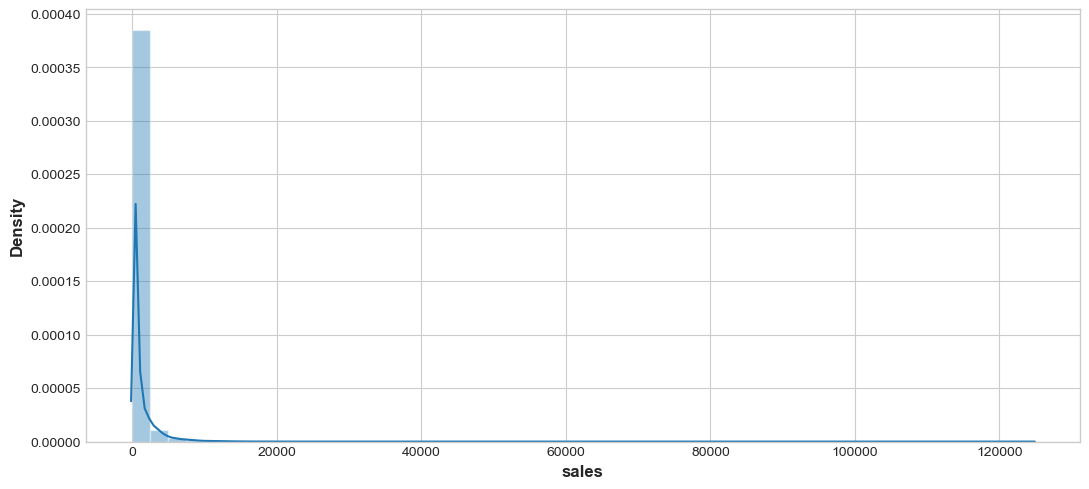

In [33]:
sns.distplot(a=data.sales)

Nos données sur les ventes ne suivent pas une courbe en cloche, nous pouvons transformer ces données avec un logarithme pour les rendre aussi "normales" que possible afin que les résultats de l'analyse statistique de ces données deviennent plus valides.

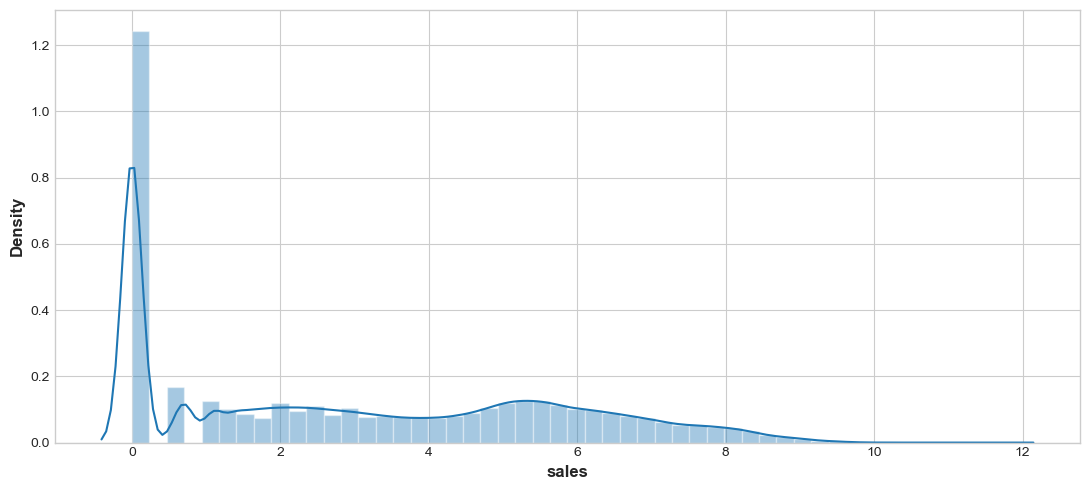

In [34]:
sns.distplot(a=np.log1p(data.sales))

 On peut remarquer que la transformation logarithmique a rapproché nos données d'une distribution normale. Nous allons donc utiliser cette transformation comme valeur cible de notre modèle et appliquer l'exponentiel lors des predictions.

### 3.4. Tendance

La composante tendancielle d'une série temporelle représente un changement persistant et à long terme de la moyenne de la série.

Faisons un tracé de moyenne mobile pour voir quel est le type de tendance de la série d'une famille de produits dans un magasin. Étant donné que cette série comporte des observations quotidiennes, choisissons une fenêtre de 365 jours pour lisser les changements à court terme au cours de l'année.

In [35]:
print(data.date.min())
print(data.date.max())

2013-01-01
2017-08-31


In [36]:
STORE_NBR = '44'  # 1 - 54
FAMILY = 'GROCERY I'

stores_data = data.loc[data.date.isin(train.date)].set_index('date')
stores_data = stores_data[stores_data.family == FAMILY]
stores_data = stores_data.drop(['family'], axis=1)
stores_data.head()

store_nbr   sales  onpromotion holiday_type  holiday  local_holiday  regional_holiday   city      state type cluster
date                                                                                                                           
2013-01-01         1    0.00            0      Holiday        1              0                 0  Quito  Pichincha    D      13
2013-01-02         1 2652.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-03         1 2121.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-04         1 2056.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-05         1 2216.00            0     Work Day        1              0                 0  Quito  Pichincha    D      13

In [37]:
ts_stores_data = stores_data.reset_index()[["store_nbr", "date", "sales"]]
ts_stores_data = ts_stores_data.set_index(['store_nbr', 'date']).sort_index()
ts_stores_data = ts_stores_data.unstack(['store_nbr'])
ts_stores_data.shape

(1684, 54)

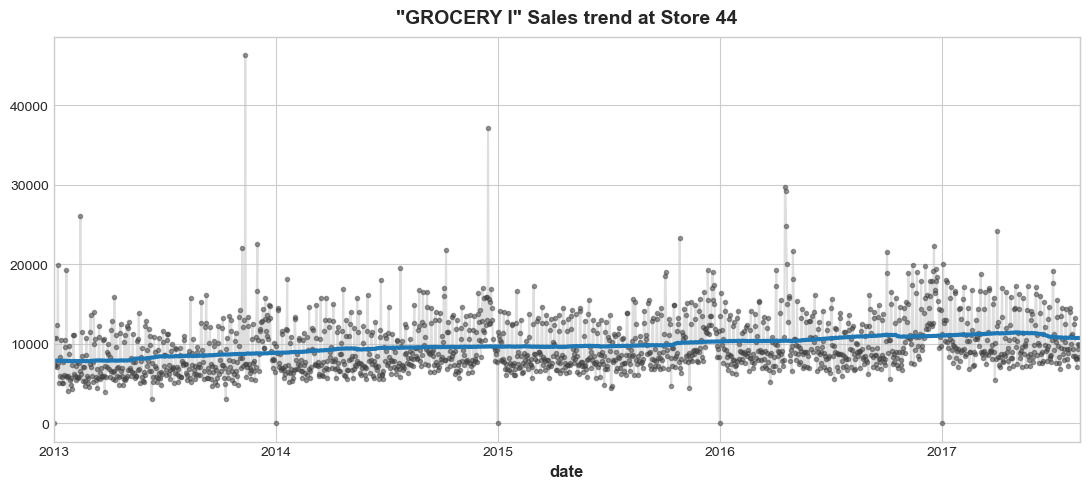

In [38]:
df = ts_stores_data.loc(axis=1)['sales', STORE_NBR]
trend = df.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = df.plot(**plot_params, alpha=0.5, title=f'"{FAMILY}" Sales trend at Store {STORE_NBR}')
ax = trend.plot(ax=ax, linewidth=3)

La régression linéaire avec une **variable de pas de temps** nous donne également un ajustement de la courbe des tendances.

Après observation des moyennes mobiles, nous utiliserons un ordre polynomial de 3 sur la **variable de pas de temps** pour ajuster notre courbe de regression à la tendance de nos données.

Pour effectuer une prévision de la tendance, nous appliquons notre modèle à des entités "hors échantillon". "Hors échantillon" fait référence aux périodes en dehors de la période d'observation des données d'apprentissage.

In [39]:
y_train, y_test = ts_stores_data[:"2017-07-30"], ts_stores_data["2017-07-31":]
dp = DeterministicProcess(index=y_train.index, order=3)
X_train = dp.in_sample()
X_test = dp.out_of_sample(steps=len(y_test))

model = LinearRegression().fit(X_train, y_train)

y_pred = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

Training RMSLE: 1.42515
Validation RMSLE: 0.23862


In [40]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_lcv = MultiTaskLassoCV(cv=kfold).fit(X_train, y_train)

y_pred = pd.DataFrame(model_lcv.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model_lcv.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

print("Alpha:", model_lcv.alpha_)

Training RMSLE: 1.75288
Validation RMSLE: 0.30994
Alpha: 17036562063.964127


In [41]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_rcv = RidgeCV(cv=kfold).fit(X_train, y_train)

y_pred = pd.DataFrame(model_rcv.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model_rcv.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

print("Alpha:", model_rcv.alpha_)

Training RMSLE: 1.42515
Validation RMSLE: 0.23862
Alpha: 10.0


In [42]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_encv = MultiTaskElasticNetCV(cv=kfold).fit(X_train, y_train)

y_pred = pd.DataFrame(model_encv.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model_encv.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

print("Alpha:", model_encv.alpha_)
print('l1_ratio_:', model_encv.l1_ratio_)

Training RMSLE: 1.75288
Validation RMSLE: 0.30994
Alpha: 34073124127.928257
l1_ratio_: 0.5


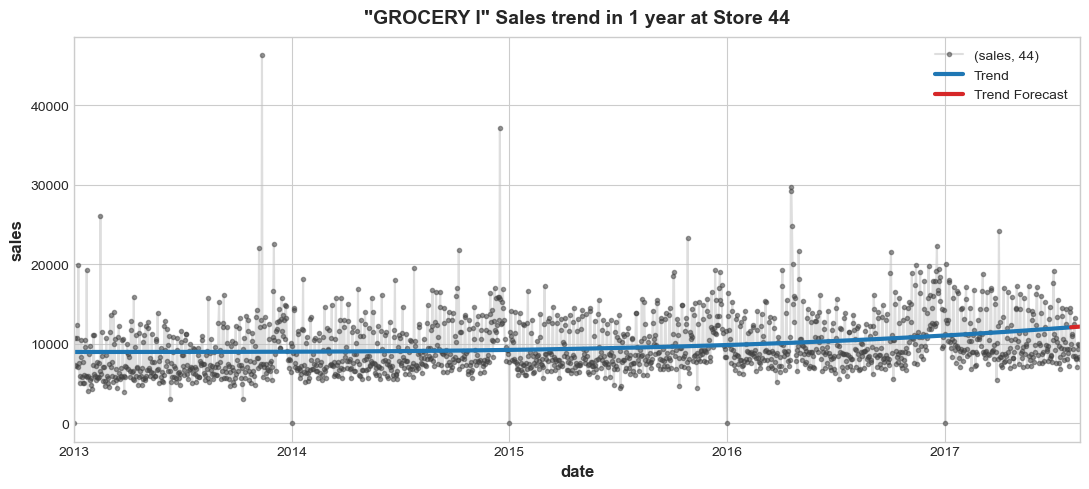

In [43]:
ax = ts_stores_data.loc(axis=1)['sales', STORE_NBR] \
    .plot(**plot_params, alpha=0.5, title=f'"{FAMILY}" Sales trend in 1 year at Store {STORE_NBR}', ylabel="sales")
ax = y_pred.loc(axis=1)['sales', STORE_NBR] \
    .plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_test_pred.loc(axis=1)['sales', STORE_NBR] \
    .plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

In [44]:
del df, trend, dp, X_train, X_test, y_train, y_test, y_pred, y_test_pred, kfold, model, model_lcv, model_rcv, model_encv, ax
gc.collect()

3165

### 3.5. Saisonnalité

Nous disons qu'une série temporelle présente une saisonnalité chaque fois qu'il y a un changement régulier et périodique dans la moyenne de la série. Tout comme nous avons utilisé un diagramme de moyenne mobile pour découvrir la tendance d'une série, nous pouvons utiliser un diagramme saisonnier pour découvrir des modèles saisonniers.

#### 3.5.1. Indicateurs saisonniers

Les indicateurs saisonniers sont des variables catégorielles qui représentent les différences saisonnières d'une série temporelle. Ces indicateurs peuvent être le jour de la semaine, du mois ou de l'année.

In [45]:
df = ts_stores_data.loc(axis=1)['sales', STORE_NBR]
df.name = "sales"
X = df.to_frame()
X['year'] = (X.index + pd.to_timedelta(3 - X.index.weekday, unit='d')).year
X['week_of_year'] = (X.index + pd.to_timedelta(3 - X.index.weekday, unit='d')).weekofyear
X = X.resample('W').mean()
px.line(X, x="week_of_year", y="sales", color="year", title=f'Weekly "{FAMILY}" Sales at Store {STORE_NBR}')

In [46]:
X = df.to_frame()
X["year"] = X.index.year
X["month"] = X.index.month
X = X.resample('M').mean()
px.line(X, x="month", y="sales", color="year", title=f'Monthly "{FAMILY}" Sales at Store {STORE_NBR}')

In [47]:
X = df.to_frame()
X["year"] = X.index.year
X["day_of_year"] = X.index.dayofyear
px.line(X, x="day_of_year", y="sales", color="year", title=f'Daily "{FAMILY}" Sales per year at Store {STORE_NBR}')

In [48]:
X = df.to_frame()
X["week_of_year"] = X.index.weekofyear
X["day_of_week"] = X.index.dayofweek
X = X.loc["2017"]
px.line(X, x="day_of_week", y="sales", color="week_of_year",
        title=f'Daily "{FAMILY}" Sales per week at Store {STORE_NBR}')

In [49]:
X = df.to_frame()
X["month"] = X.index.month
X["day"] = X.index.day
X = X.loc["2015"]
px.line(X, x="day", y="sales", color="month", title=f'Daily "{FAMILY}" Sales per month at Store {STORE_NBR}')

Les notes du jeu de données indiquent que les salaires dans le secteur public sont versés toutes les deux semaines, le 15 et le dernier jour du mois. De plus, nous constatons que les ventes ont tendance à varier davantage autour des mêmes périodes, en particulier en fin et en début de mois.

In [50]:
del df, X
gc.collect()

1042

#### 3.5.2. Analyse spectrale

Le principe sur lequel repose l’analyse spectrale est que toute fonction périodique est la somme de fonctions
périodiques simples (fonctions sinus et cosinus). Cette somme est appelée décomposition en séries de Fourier. 

Les series de Fourier permettent de modéliser la saisonnalité d'une série temporelle. Ils permettent de capturer la forme globale de la courbe saisonnière avec une paire de fonctions sinus et cosinus pour chaque fréquence potentielle de la saison d'une série.

Combien de paires de fonctions devrions-nous inclure dans notre ensemble de fonctionnalités ? Nous pouvons répondre à cette question avec le périodogramme qui est une transformée de Fourrier discrète.
 
Le périodogramme nous indique la force des fréquences dans une série temporelle. Plus précisément, la valeur sur l'axe y de ce graphique est `(a ** 2 + b ** 2) / 2`, où `a` et `b` sont respectivement les coefficients du sinus et du cosinus à cette fréquence.

In [51]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

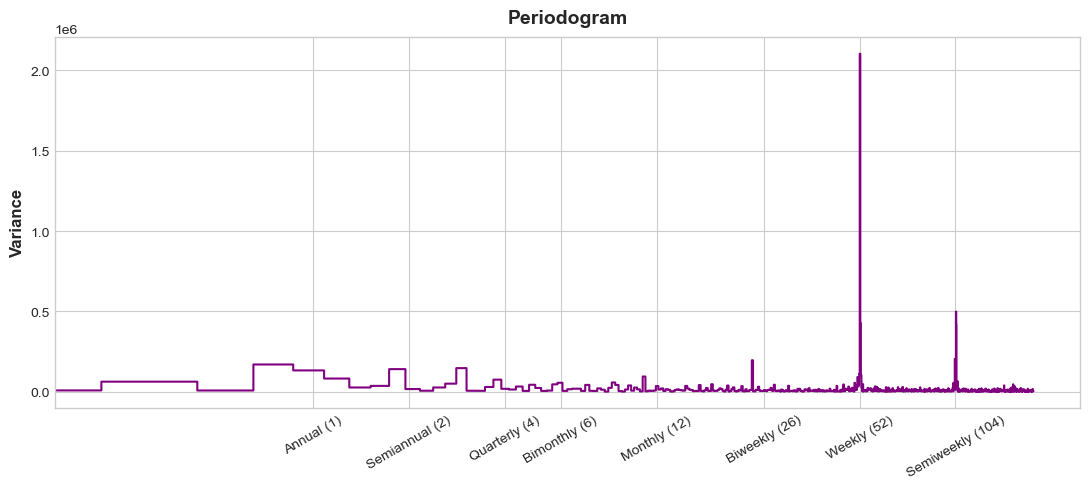

In [52]:
plot_periodogram(ts_stores_data.loc(axis=1)['sales', STORE_NBR])

Le périodogramme suggèrent une forte saisonnalité hebdomadaire.

La forte saisonnalité hebdomadaire sera modélisé par une série de fourier d'ordre `3`. L'ordre `3` est l'expansion de Fourier ou le nombre de vagues (une vague équivalente à une montée et une descente) que nous attendons dans la fréquence choisie et qui est visibles ci-dessus sur le graphique des ventes journalières par semaine.

Nous pouvons donc créer nos variables saisonnières à l'aide de DeterministicProcess et CalendarFourier.

In [53]:
y_train, y_test = ts_stores_data[:"2017-07-30"], ts_stores_data["2017-07-31":]
fourier = CalendarFourier(freq='W', order=3)
dp = DeterministicProcess(
    index=y_train.index,
    constant=True,  # dummy feature for bias (y-intercept)
    order=3,  # Trend
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X_train = dp.in_sample()
# Indicateurs saisonniers
X_train['year'] = X_train.index.year.astype(int)
X_train["month"] = X_train.index.month.astype(int)
X_train['week_of_year'] = X_train.index.weekofyear.astype(int)
X_train["day_of_week"] = X_train.index.dayofweek.astype(int)
X_train["day_of_year"] = X_train.index.dayofyear.astype(int)

X_test = dp.out_of_sample(steps=len(y_test))
# Indicateurs saisonniers
X_test['year'] = X_test.index.year.astype(int)
X_test["month"] = X_test.index.month.astype(int)
X_test['week_of_year'] = X_test.index.weekofyear.astype(int)
X_test["day_of_week"] = X_test.index.dayofweek.astype(int)
X_test["day_of_year"] = X_test.index.dayofyear.astype(int)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_pred = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

Training RMSLE: 1.42863
Validation RMSLE: 0.22511


In [54]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_rcv = RidgeCV(cv=kfold, fit_intercept=False).fit(X_train, y_train)

y_pred = pd.DataFrame(model_rcv.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model_rcv.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

print("Alpha:", model_rcv.alpha_)

Training RMSLE: 1.42762
Validation RMSLE: 0.22566
Alpha: 10.0


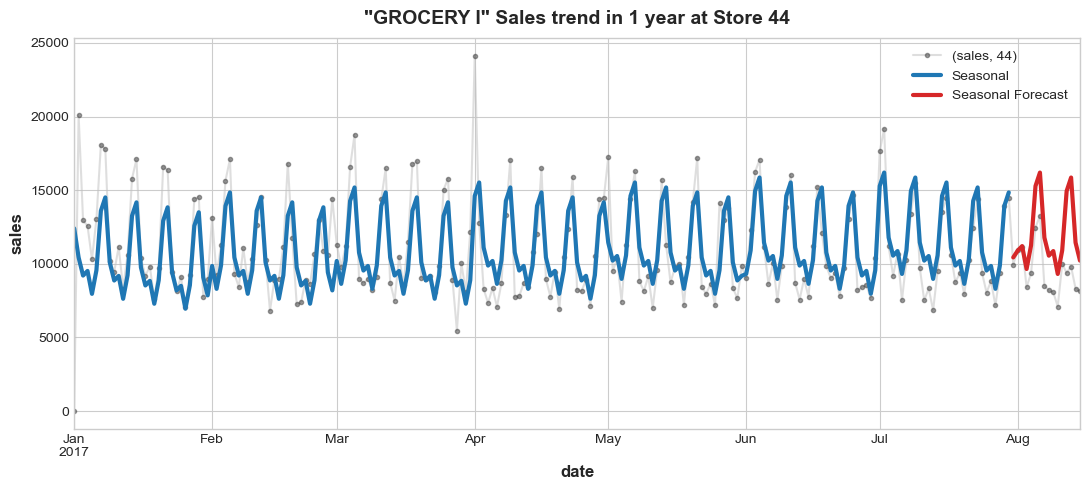

In [55]:
ax = ts_stores_data.loc(axis=1)['sales', STORE_NBR].loc["2017"] \
    .plot(**plot_params, alpha=0.5, title=f'"{FAMILY}" Sales trend in 1 year at Store {STORE_NBR}', ylabel="sales")
ax = y_pred.loc(axis=1)['sales', STORE_NBR].loc["2017"] \
    .plot(ax=ax, linewidth=3, label="Seasonal", color='C0')
ax = y_test_pred.loc(axis=1)['sales', STORE_NBR] \
    .plot(ax=ax, linewidth=3, label="Seasonal Forecast", color='C3')
ax.legend()

Supprimer d'une série sa tendance ou ses saisons s'appelle détendre ou désaisonnaliser la série. Regardons le périodogramme de la série désaisonnalisée.

Text(0.5, 1.0, 'Deseasonalized')

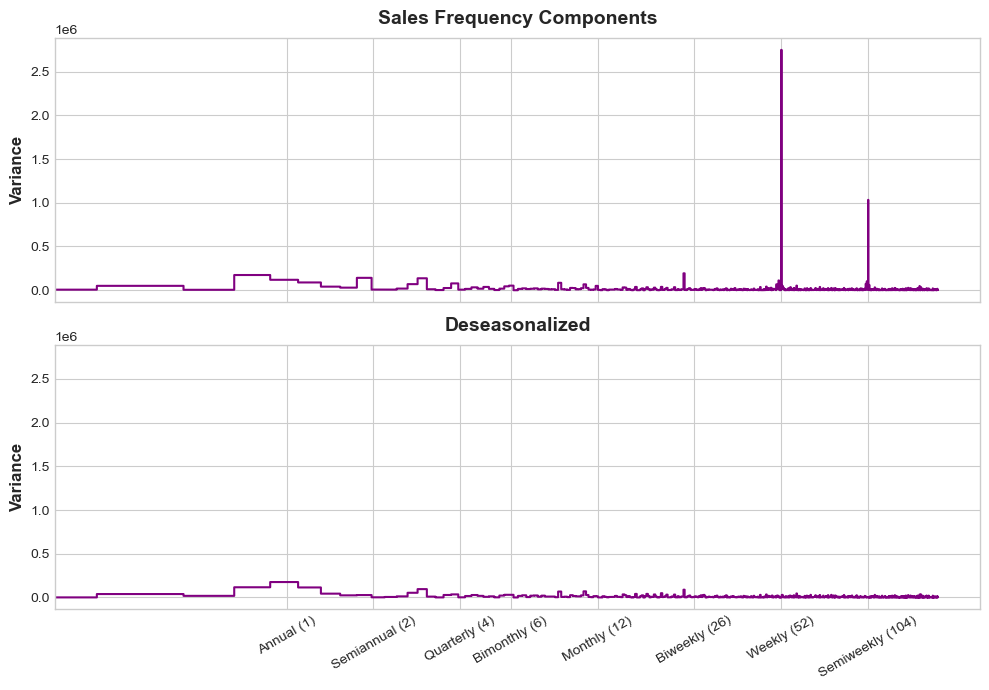

In [56]:
y_deseason = y_train - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y_train.loc(axis=1)['sales', STORE_NBR], ax=ax1)
ax1.set_title("Sales Frequency Components")
ax2 = plot_periodogram(y_deseason.loc(axis=1)['sales', STORE_NBR], ax=ax2);
ax2.set_title("Deseasonalized")

Le périodogramme de la série désaisonnalisée n'a plus de fortes fréquences. En le comparant au périodogramme de la série originale, nous pouvons voir que notre modèle a pu capturer les fortes variations saisonnières des ventes. Mais il reste des résidus qui pourraient être interpreter par d'autres variables indépendantes tels que les dépendances en série.

### 3.6. Dépendance en série

Certaines propriétés de séries temporelles ne peuvent être modélisées qu'en tant que propriétés dépendantes de la série, c’est-à-dire en utilisant comme variables indépendantes les valeurs passées de la série cible. La structure de ces séries temporelles peut ne pas être apparente à partir d’un graphique au fil du temps. Cependant, tracée par rapport aux valeurs passées, la structure peut devenir claire.

In [204]:
FAMILY = 'SCHOOL AND OFFICE SUPPLIES'
# FAMILY = 'GROCERY I'

stores_data = data.loc[data.date.isin(train.date)].set_index('date')
stores_data = stores_data[stores_data.family == FAMILY]
stores_data = stores_data.drop(['family'], axis=1)
stores_data.head()

store_nbr  sales  onpromotion holiday_type  holiday  local_holiday  regional_holiday   city      state type cluster
date                                                                                                                          
2013-01-01         1   0.00            0      Holiday        1              0                 0  Quito  Pichincha    D      13
2013-01-02         1   0.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-03         1   0.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-04         1   0.00            0           No        0              0                 0  Quito  Pichincha    D      13
2013-01-05         1   0.00            0     Work Day        1              0                 0  Quito  Pichincha    D      13

In [205]:
ts_stores_data = stores_data.reset_index()[["store_nbr", "date", "sales", "onpromotion"]]
ts_stores_data = ts_stores_data.set_index(['store_nbr', 'date']).sort_index()
ts_stores_data = ts_stores_data.unstack(['store_nbr'])
ts_stores_data.shape

(1684, 108)

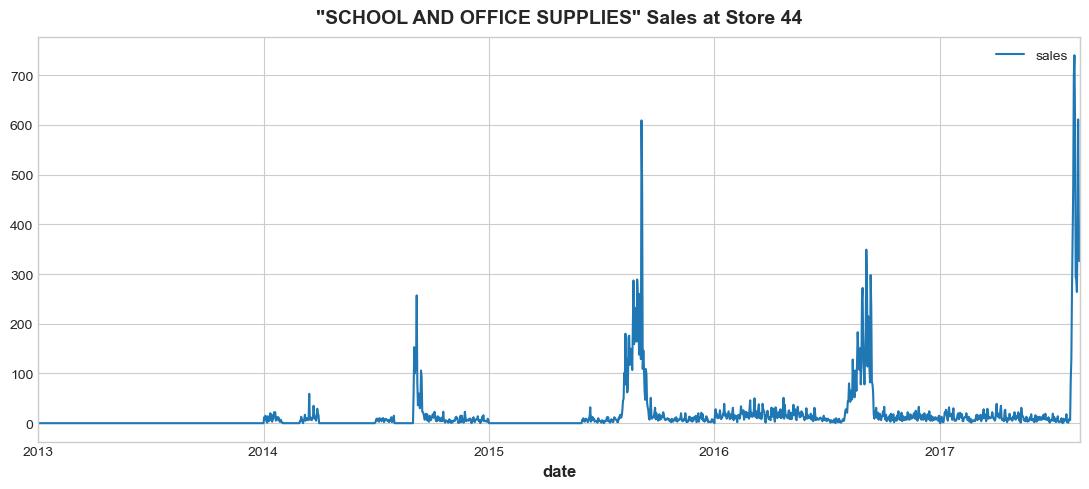

In [218]:
y = ts_stores_data.loc[:, 'sales'].squeeze()
ax = y.loc(axis=1)[STORE_NBR].rename('sales').plot()
ax.set_title(f'"{FAMILY}" Sales at Store {STORE_NBR}')
ax.legend()

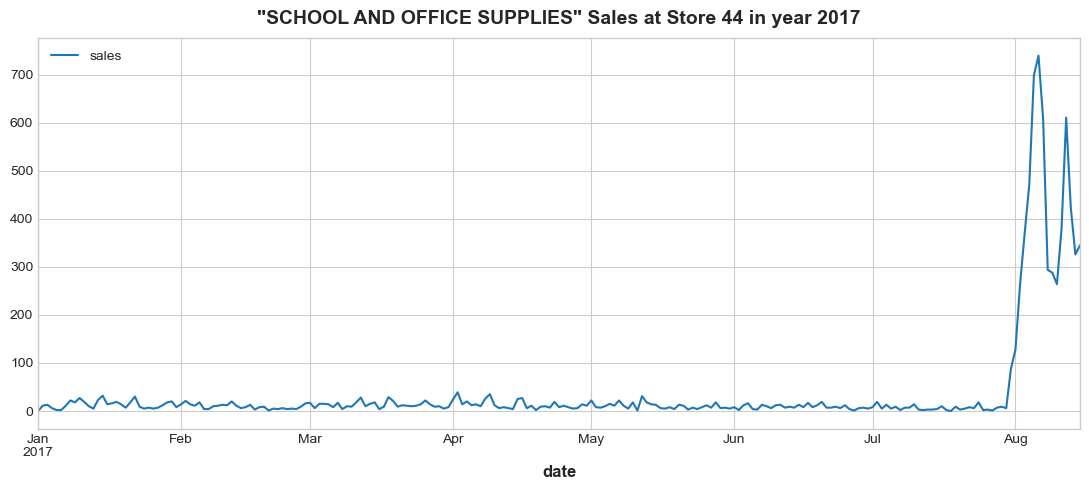

In [60]:
ax = y.loc(axis=1)[STORE_NBR].loc["2017"].rename('sales').plot()
ax.set_title(f'"{FAMILY}" Sales at Store {STORE_NBR} in year 2017')
ax.legend()

In [61]:
X = y.loc(axis=1)[STORE_NBR]
X.name = "sales"
X = X.to_frame()
X["year"] = X.index.year
X["month"] = X.index.month
X = X.resample('M').mean()
px.line(X, x="month", y="sales", color="year", title=f'Monthly "{FAMILY}" Sales at Store {STORE_NBR}')

Toutes les familles de produits n'ont pas des ventes présentant un comportement saisonnier, pas plus que la série des ventes.

Les ventes de fournitures scolaires et de bureau, cependant, montrent des schémas de croissance et de décroissance qui ne sont pas trés bien caractérisés par des tendances ou des saisons.

Nous allons donc modéliser les cycles de vente de fournitures scolaires et de bureau à l'aide de fonctions de décalage en plus des variables de saisonnalité et de tendance.

La tendance et la saisonnalité créeront toutes deux une dépendance sérielle qui apparaît dans un corrélogramme et des graphiques de décalage. Pour isoler tout comportement purement cyclique, nous commencerons par désaisonnaliser la série.


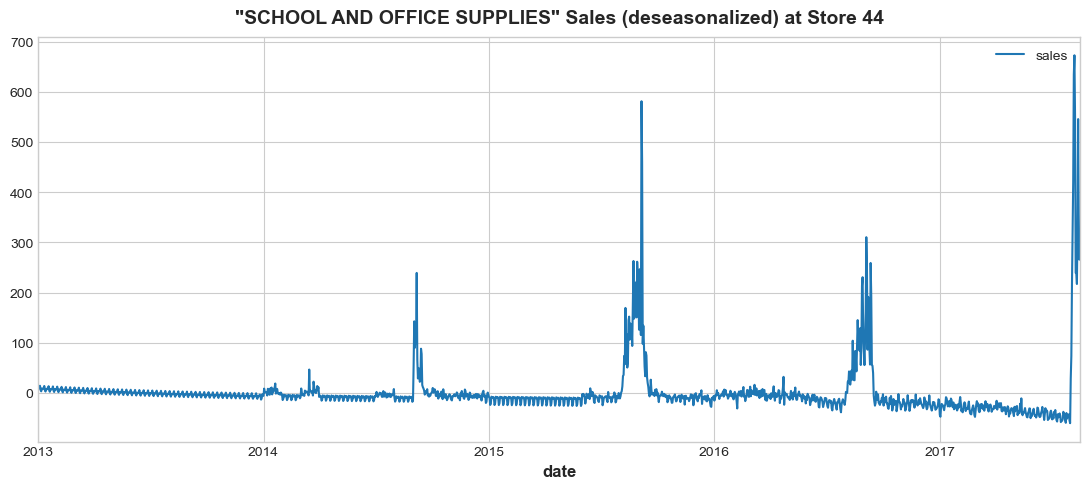

In [219]:
fourier = CalendarFourier(freq='W', order=3)
dp = DeterministicProcess(
    constant=True,  # dummy feature for bias (y-intercept)
    index=y.index,
    order=3,  # trend (order 1 means linear)
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()

seasonal_model = Ridge(fit_intercept=False, alpha=10)
seasonal_model.fit(X_time, y)

y_deseason = y - seasonal_model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.loc(axis=1)[STORE_NBR].rename('sales').plot()
ax.set_title(f'"{FAMILY}" Sales (deseasonalized) at Store {STORE_NBR}')
ax.legend()

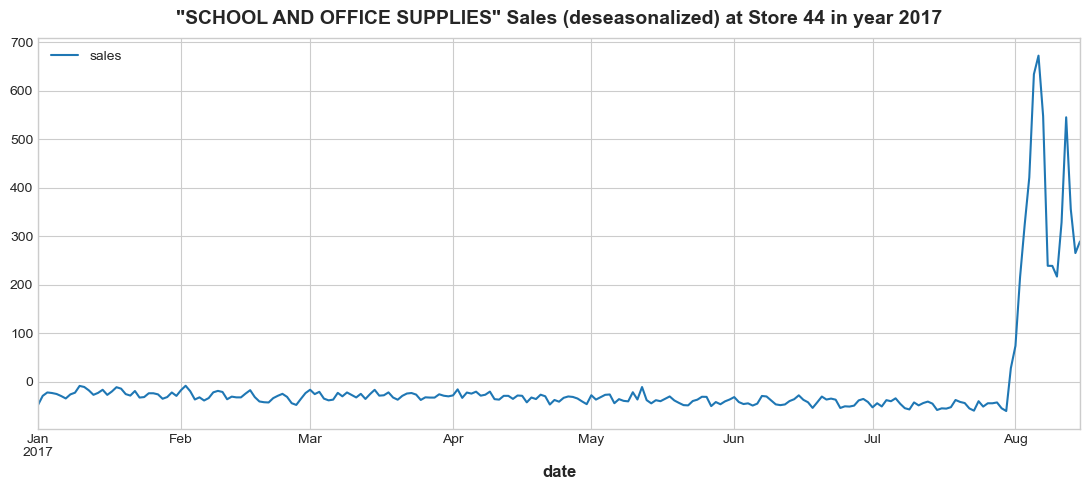

In [63]:
ax = y_deseason.loc(axis=1)[STORE_NBR].loc["2017"].rename('sales').plot()
ax.set_title(f'"{FAMILY}" Sales (deseasonalized) at Store {STORE_NBR} in year 2017')
ax.legend();


Examinons notre série désaisonnalisée pour la dépendance sérielle à partir d'un corrélogramme d'auto-corrélation partielle et des graphiques de décalage.

In [64]:
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, leads=None, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

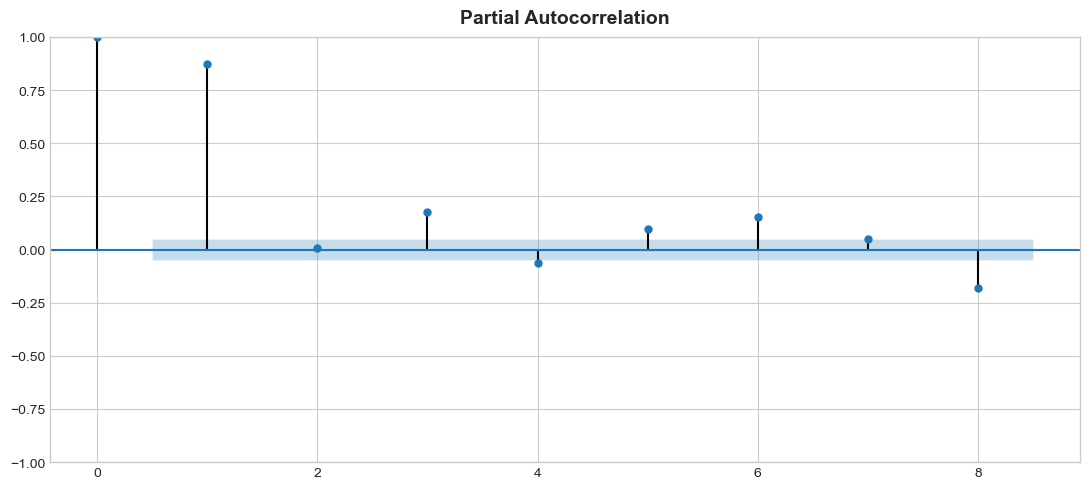

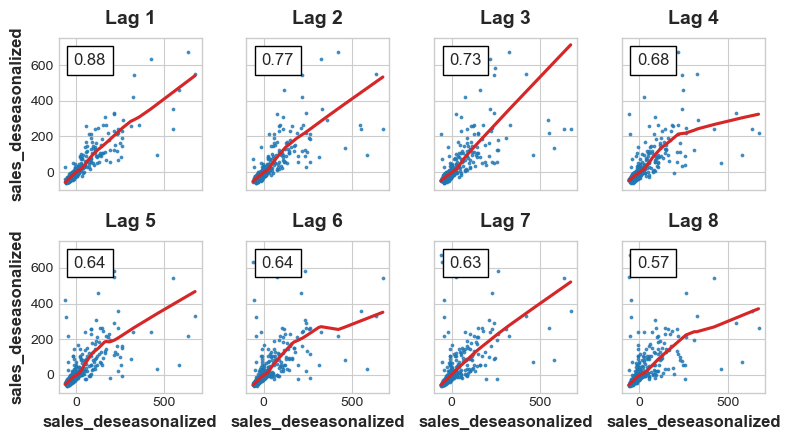

In [65]:
plot_pacf(y_deseason.loc(axis=1)[STORE_NBR], lags=8);
plot_lags(y_deseason.loc(axis=1)[STORE_NBR].rename('sales_deseasonalized'), lags=8, nrows=2);

Le corrélogramme indique que le premier décalage est susceptible d'être significatif, mais dans une moindre mésure le troisième, le cinquième, le sixième et le huitième décalage. Le diagramme de décalage suggère que l'effet soit principalement linéaire.

#### 3.6.1. Série des ventes en promotion

L'ensemble de données comprend une série temporelle qui pourrait potentiellement être utile comme indicateur avancé : la série `onpromotion`, contenant le nombre d'articles bénéficiant d'une promotion spéciale lors d'une journée. Un indicateur avancé est une série dont les valeurs à un moment donné peuvent être utilisées pour prédire une cible à un moment futur. Il fournit un "préavis" des changements dans la cible.

Examinons les valeurs avancées et retardées pour la variable `onpromotion` tracées par rapport aux ventes de la famille des fournitures scolaires et de bureau.

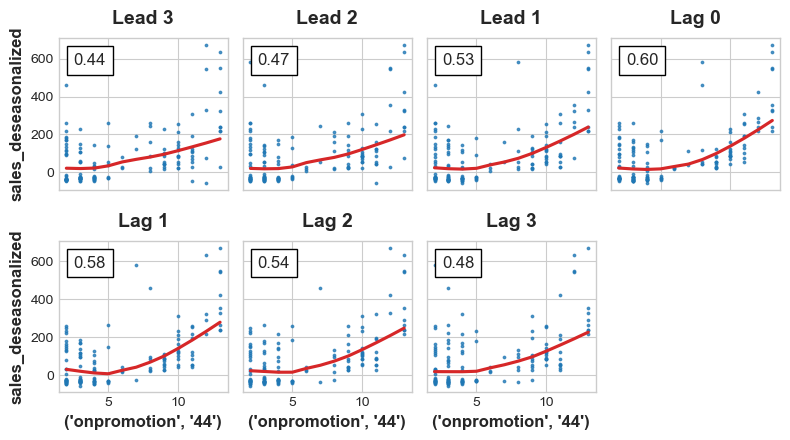

In [208]:
onpromotion = ts_stores_data.loc(axis=1)['onpromotion', STORE_NBR].squeeze()
plot_lags(x=onpromotion.loc[onpromotion > 1],
          y=y_deseason.loc(axis=1)[STORE_NBR].rename('sales_deseasonalized').loc[onpromotion > 1],
          lags=3, leads=3, nrows=2);

Le graphique des décalages indique que les valeurs retardées et décalées de la variable `onpromotion` sont corrélées avec les ventes. Cela suggère que les deux types de valeurs pourraient être utiles en tant que fonctionnalités. Il peut également y avoir des effets non linéaires.

Créons des variables de décalage pour les ventes et les promotions.

In [210]:
def make_lags(ts, lags, name, lead_time=1):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(1, leads + 1))},
        axis=1)

In [224]:
X_lags = make_lags(y_deseason, lags=1, name="y_deseason").stack()

onpromotion = ts_stores_data.loc[:, 'onpromotion']
X_promo = pd.concat([
    make_lags(onpromotion, lags=1, name="onpromotion").stack(),
    # onpromotion.stack().rename('onpromotion'),
    # make_leads(onpromotion, leads=1, name="onpromotion").stack(),
], axis=1)
X = pd.merge(X_lags, X_promo, how="left", left_index=True, right_index=True)
X = X.unstack(['store_nbr']).dropna()
X['year'] = X.index.year.astype(int)
X["month"] = X.index.month.astype(int)
X['week_of_year'] = X.index.weekofyear.astype(int)
X["day_of_week"] = X.index.dayofweek.astype(int)
X["day_of_year"] = X.index.dayofyear.astype(int)

X_time = X_time[X.index.min():X.index.max()]
y = y[X.index.min():X.index.max()]
y_deseason = y_deseason[X.index.min():X.index.max()]
print(X.shape)
print(X_time.shape)
print(y.shape)
print(y_deseason.shape)

(1681, 113)
(1681, 16)
(1681, 54)
(1681, 54)


Observons maintenant les prédictions du modèle résultant.

In [225]:
y_train, y_test = y[:"2017-07-30"], y["2017-07-31":]
y_deseason_train, y_deseason_test = y_deseason[:"2017-07-30"], y_deseason["2017-07-31":]
X_train, X_test = X[:"2017-07-30"], X["2017-07-31":]
X_time_train, X_time_test = X_time[:"2017-07-30"], X_time["2017-07-31":]

series_model = LinearRegression(fit_intercept=False).fit(X_train, y_deseason_train)

y_pred = pd.DataFrame(series_model.predict(X_train) + seasonal_model.predict(X_time_train),
                      index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(series_model.predict(X_test) + seasonal_model.predict(X_time_test),
                           index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

Training RMSLE: 0.58192
Validation RMSLE: 1.32847


In [70]:
kfold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model_rcv = RidgeCV(cv=kfold, fit_intercept=False).fit(X_train, y_deseason_train)

y_pred = pd.DataFrame(model_rcv.predict(X_train) + seasonal_model.predict(X_time_train),
                      index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model_rcv.predict(X_test) + seasonal_model.predict(X_time_test),
                           index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    y_train.stack(['store_nbr']),
    y_pred.stack(['store_nbr']),
    y_test.stack(['store_nbr']),
    y_test_pred.stack(['store_nbr']))

print("Alpha:", model_rcv.alpha_)

Training RMSLE: 0.54946
Validation RMSLE: 1.22647
Alpha: 10.0


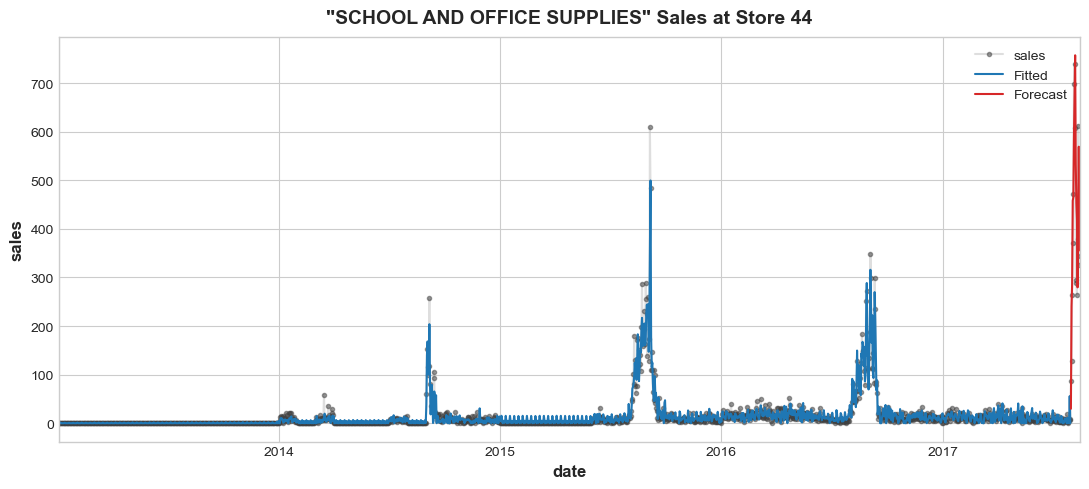

In [71]:
ax = y.loc(axis=1)[STORE_NBR].rename('sales').plot(**plot_params, alpha=0.5, ylabel="sales")
ax.set_title(f'"{FAMILY}" Sales at Store {STORE_NBR}')
ax = y_pred.loc(axis=1)[STORE_NBR].plot(ax=ax, label="Fitted", color='C0')
ax = y_test_pred.loc(axis=1)[STORE_NBR].plot(ax=ax, label="Forecast", color='C3')
ax.legend();

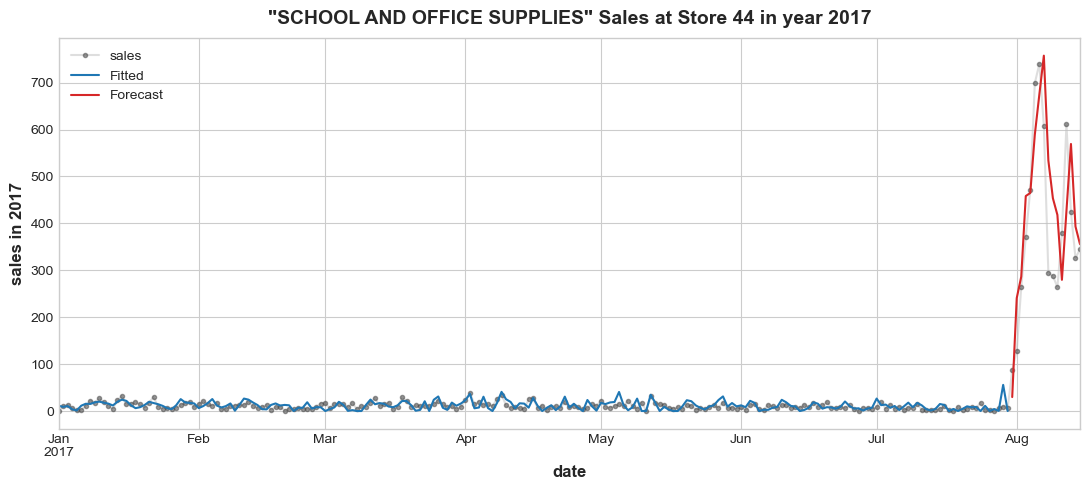

In [72]:
ax = y.loc(axis=1)[STORE_NBR].loc["2017"].rename('sales').plot(**plot_params, alpha=0.5, ylabel="sales in 2017")
ax = y_pred.loc(axis=1)[STORE_NBR].loc["2017"].plot(ax=ax, label="Fitted", color='C0')
ax = y_test_pred.loc(axis=1)[STORE_NBR].loc["2017"].plot(ax=ax, label="Forecast", color='C3')
ax.set_title(f'"{FAMILY}" Sales at Store {STORE_NBR} in year 2017')
ax.legend();

#### 3.6.2. Série des prix du pétrole

L’économie est l’un des plus gros problèmes pour les gouvernements et le peuple. Cela affecte toutes les choses dans le bon ou le mauvais sens. Dans notre cas, l’Équateur est un pays dépendant du pétrole. La modification des prix du pétrole en Équateur pourrait entertainer une variation dans le modèle.


In [73]:
oil.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [74]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

Il y a des points de données manquants dans les données pétrolières quotidiennes. Utilisons l’interpolation linéaire pour les corriger.

In [75]:
# Resample
oil = oil.set_index("date")["2013-01-02":].dcoilwtico.resample("D").sum().reset_index()
# Interpolate
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] = oil.dcoilwtico.interpolate()
oil.isna().sum()

date                         0
dcoilwtico                 528
dcoilwtico_interpolated      0
dtype: int64

In [76]:
X = oil.copy()
X["date"] = X.date.dt.to_timestamp()
p = X.melt(id_vars=['date'] + list(X.keys()[5:]), var_name='Legend')
px.line(p.sort_values(["Legend", "date"], ascending=[False, True]), x='date', y='value', color='Legend',
        title="Daily Oil Price")

Vérifions la corrélation entre les prix du pétrole et les ventes totales.

In [77]:
df = data.loc[data.date.isin(train.date)]
df = pd.merge(df[["date", "sales"]].groupby("date").sum(),
              oil.set_index("date"), how="left",
              left_index=True, right_index=True)
print("Corrélation avec les prix quotidiens du pétrole")
print(df.drop(["dcoilwtico"], axis=1).corr("spearman").dcoilwtico_interpolated.loc[["sales"]], "\n")

Corrélation avec les prix quotidiens du pétrole
sales   -0.61
Name: dcoilwtico_interpolated, dtype: float64 


La valeur de la corrélation n'est pas très forte et le signe est négatif. Logiquement, si le prix quotidien du pétrole est élevé, nous nous attendons à ce que l'économie de l'Équateur soit mauvaise et cela signifie que le prix des produits augmente et que les ventes diminuent.

Vérifions les graphiques des décalages temporelles pour une boutique et une famille de produits.

In [78]:
df = oil.set_index("date")["dcoilwtico_interpolated"].rename("dcoilwtico").to_frame()
ts_stores_data = stores_data.reset_index()[["store_nbr", "date", "sales", "onpromotion"]]
ts_stores_data = ts_stores_data.set_index(['store_nbr', 'date']).sort_index()
ts_stores_data = pd.merge(ts_stores_data, df, how="left", left_index=True, right_index=True).dropna()
ts_stores_data = ts_stores_data.unstack(['store_nbr'])

ts_stores_data.shape

(1683, 162)

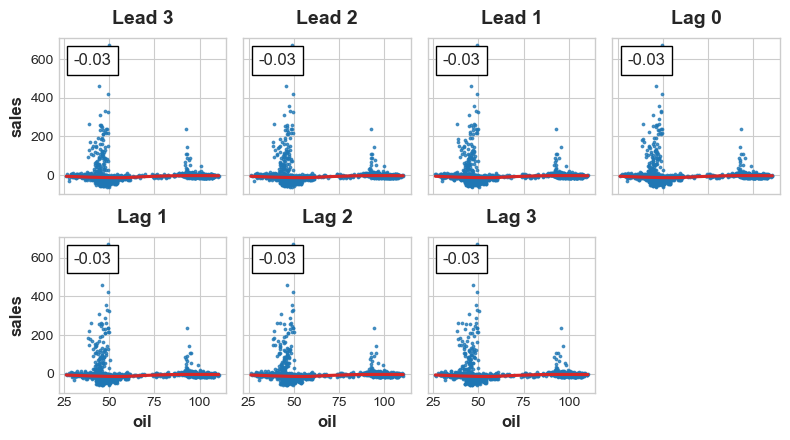

In [79]:
plot_lags(x=ts_stores_data.loc(axis=1)['dcoilwtico', STORE_NBR].squeeze().rename('oil'),
          y=y_deseason["2013-01-02":].loc(axis=1)[STORE_NBR].rename('sales'),
          lags=3, leads=3, nrows=2);

## 4. Prédictions des séries temporelles

### 4.1. Préparation des séries temporelles multiples à prédire

Avant d'utiliser nos données pour les prévisions, nous devons identifier le type de modèles à utiliser. Les modèles statistiques traditionnels comme ARIMA se concentrent sur la prévision d'une seule série cible par modèle. Comme nous avons 1782 séries cibles, la construction de 1782 modèles peut être coûteuse en calcul. Nous pouvons ainsi concevoir un modèle permettant de prévoir plusieurs séries en utilisant des informations partagées.

Cependant, l'utilisation d'un modèle unique peut compliquer la représentation précise de toutes les variables pertinentes. Un compromis consisterait à utiliser plusieurs modèles, où chaque modèle prévoit un groupe spécifique de séries cibles. Il est alors logique que chaque groupe de séries cibles soit de nature similaire, ce qui permet aux modèles de capturer les modèles uniques au sein de chaque groupe.

Nous pouvons regrouper les séries de plusieurs manières. Les problèmes de ventes est lié au type de produits vendus, ce qui suggère que chaque produit a ses caractéristiques uniques. En tant que tel, une approche raisonnable serait d'avoir un modèle par famille de produits, nous avons donc un total de 33 modèles.

Il est important de sélectionner correctement la période d'entraînement pour les 33 modèles. Certains magasins ont des ventes nulles jusqu'à une certaine date, or nous voulons des périodes où toutes les données d'un magasin sont disponibles pour avoir des series temporelles de même taille. Pour chaque date d'ouverture, nous pouvons ainsi implémenter 33 modèles pours les magasins correspondants.

Séparons maintenant les données d'entrainement en fonction des dates d'ouverture des magasins.

In [80]:
data_train = data[(data.date >= '2013-01-02')]

print(data_train.shape)
print(data_train.date.min())
print(data_train.date.max())
data_train.head()

(2938419, 13)
2013-01-02
2017-08-31


date store_nbr      family  sales  onpromotion holiday_type  holiday  local_holiday  regional_holiday   city      state type cluster
1  2013-01-02         1  AUTOMOTIVE   2.00            0           No        0              0                 0  Quito  Pichincha    D      13
2  2013-01-03         1  AUTOMOTIVE   3.00            0           No        0              0                 0  Quito  Pichincha    D      13
3  2013-01-04         1  AUTOMOTIVE   3.00            0           No        0              0                 0  Quito  Pichincha    D      13
4  2013-01-05         1  AUTOMOTIVE   5.00            0     Work Day        1              0                 0  Quito  Pichincha    D      13
5  2013-01-06         1  AUTOMOTIVE   2.00            0           No        0              0                 0  Quito  Pichincha    D      13

In [81]:
stores_open_date = data_train.reset_index()[["date", "store_nbr", "sales"]].groupby(
    ["date", "store_nbr"]).sum().reset_index()
stores_open_date = (stores_open_date[stores_open_date["sales"] > 0].groupby("store_nbr")[["date"]].min() \
                    .sort_values(by="date", ascending=True)).reset_index()
stores_open_date.rename(columns={'date': 'open_date'}, inplace=True)
print(stores_open_date.shape)
stores_open_date.head()

(54, 2)


store_nbr   open_date
0         1  2013-01-02
1        34  2013-01-02
2        35  2013-01-02
3        37  2013-01-02
4        38  2013-01-02

In [82]:
families_list = data_train.family.unique().tolist()
stores_list = data_train.store_nbr.unique().tolist()

stores_still_to_train = stores_list.copy()
data_by_open_date = {}
non_model_stores = {}
for open_date in stores_open_date.open_date.unique():
    print("---------------------------------------------------------------------------------------------")
    print(f"Opening date : {open_date!r} ")
    stores_to_exclude = stores_open_date[stores_open_date.open_date > open_date].store_nbr.values.tolist()
    stores_to_include = [x for x in stores_still_to_train if x not in stores_to_exclude]
    stores_still_to_train = [x for x in stores_still_to_train if x not in stores_to_include]
    # stores_already_trained = [x for x in stores_list if x not in stores_to_include and x not in stores_to_exclude]
    data_by_open_date[str(open_date)] = data_train[
        (data_train.store_nbr.isin(stores_to_include) & (data_train.date >= open_date))]
    # non_model_stores[str(open_date)] = stores_already_trained
    print(f"Stores opened and to include : {stores_to_include!r}")
    print(f"Stores to exclude : {stores_to_exclude!r}", end="\n\n")
    # print(f"Stores already trained : {stores_already_trained!r}", end="\n\n")

stores_open_date = dict(zip(stores_open_date.store_nbr, stores_open_date.open_date))
del open_date, stores_to_exclude, stores_to_include
gc.collect()

---------------------------------------------------------------------------------------------
Opening date : Period('2013-01-02', 'D') 
Stores opened and to include : ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '23', '24', '25', '26', '27', '28', '3', '30', '31', '32', '33', '34', '35', '37', '38', '39', '4', '40', '41', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '54', '6', '7', '8', '9']
Stores to exclude : ['36', '53', '20', '29', '21', '42', '22', '52']

---------------------------------------------------------------------------------------------
Opening date : Period('2013-05-09', 'D') 
Stores opened and to include : ['36']
Stores to exclude : ['53', '20', '29', '21', '42', '22', '52']

---------------------------------------------------------------------------------------------
Opening date : Period('2014-05-29', 'D') 
Stores opened and to include : ['53']
Stores to exclude : ['20', '29', '21', '42', '22', '52']

-------------------------

24579

Nous aurons ainsi 9 dates d'ouverture différentes pour 33 modèles par date. Ce qui nous donne 297 modèles à entrainer.

### 4.3. Modèles hybrides

La régression linéaire excelle dans l'extrapolation des tendances, mais ne peut pas apprendre les interactions telles que les dépendances en série. XGBoost excelle dans les interactions d'apprentissage, mais ne peut pas extrapoler les tendances. Nous allons créer des modèles "hybrides" qui combinent des algorithmes d'apprentissage complémentaires et permettent aux forces de l'un de compenser la faiblesse de l'autre.

Implémentons un modèle hybride boosté pour l'ensemble des données Store Sales en créant une nouvelle classe Python.

In [83]:
class BoostedHybrid:

    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

    def fit(self, X_1, X_2, y):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )

        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack().squeeze()  # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=self.y_columns,
        )
        y_pred = y_pred.stack().squeeze()

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)

        return y_pred.unstack()


def display_result(input_x1, input_x2, input_y, input_model):
    y_arg_train, y_arg_test = input_y[:"2017-07-30"], input_y["2017-07-31":]

    # x1_train, x1_test = input_x1[: "2017-07-30"], input_x1["2017-07-31":]
    # x2_train, x2_test = input_x2.loc[:"2017-07-30"], input_x2.loc["2017-07-31":]

    x1_train, x1_test = input_x1[input_x1.index <= "2017-07-30"], input_x1[input_x1.index >= "2017-07-31"]
    x2_train, x2_test = input_x2[input_x2.index <= "2017-07-30"], input_x2[input_x2.index >= "2017-07-31"]

    input_model.fit(x1_train, x2_train, y_arg_train)

    y_arg_pred = input_model.predict(x1_train, x2_train).clip(0.0)
    y_arg_test_pred = input_model.predict(x1_test, x2_test).clip(0.0)

    print_rmsle(y_arg_train, y_arg_pred, y_arg_test, y_arg_test_pred)

    stores = input_y.columns[0:6]
    axs = input_y.loc(axis=1)[stores] \
        .plot(subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5, );
    _ = y_arg_pred.loc(axis=1)[stores].plot(subplots=True, sharex=True, color='C0', ax=axs);
    _ = y_arg_test_pred.loc(axis=1)[stores].plot(subplots=True, sharex=True, color='C3', ax=axs);
    for ax, store in zip(axs, stores):
        ax.legend([]);
        ax.set_ylabel(store);

#### 4.2.1. Premier modèle hybride

Configurons les données pour un modèle hybride.

In [84]:
# ('2013-01-02', 'SCHOOL AND OFFICE SUPPLIES')
# get ts by open date and family
stores_data = data_by_open_date['2013-01-02']
stores_data = stores_data[stores_data.date.isin(train.date)]
stores_data = stores_data[stores_data.family == 'GROCERY I']
stores_data = stores_data.drop(['family'], axis=1)

family_open_date = stores_data.reset_index()[["date", "store_nbr", "sales"]].groupby(
    ["date", "store_nbr"]).sum().reset_index()
family_open_date = (family_open_date[family_open_date["sales"] > 0].groupby("store_nbr")["date"].min()).max()

stores_data = stores_data.reset_index(drop=True).set_index(['store_nbr', 'date']).sort_index()

# Target series
ts_stores_data = stores_data.unstack(['store_nbr'])
ts_stores_data = ts_stores_data.loc[family_open_date:]
y = ts_stores_data.loc[:, 'sales']

# X_1: Features for Linear Regression
fourier = CalendarFourier(freq='W', order=3)
dp = DeterministicProcess(
    constant=True,  # dummy feature for bias (y-intercept)
    index=y.index,
    order=3,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_1 = dp.in_sample()

# X_2: Features for second model
ts_stores_data = stores_data.drop('sales', axis=1)
ts_stores_data = ts_stores_data.reset_index('store_nbr')
X_2 = ts_stores_data.loc[ts_stores_data.index >= family_open_date]
# Seasonality features
X_2['year'] = X_2.index.year.astype(int)
X_2["month"] = X_2.index.month.astype(int)
X_2['week_of_year'] = X_2.index.weekofyear.astype(int)
X_2["day_of_week"] = X_2.index.dayofweek.astype(int)
X_2["day_of_year"] = X_2.index.dayofyear.astype(int)

# X_2["store_nbr"] = 'store_' + X_2["store_nbr"].astype(str)
# enc = OneHotEncoder(handle_unknown='ignore')
# enc_df = pd.DataFrame(enc.fit_transform(X_2[['store_nbr']]).toarray(),
#                       index=X_2.index)
# X_2 = X_2.drop('store_nbr', axis=1)
# X_2 = pd.concat([X_2, enc_df], axis=1)

print(X_2.shape)
X_2 = pd.get_dummies(X_2, columns=["store_nbr", "holiday_type", "city", "state", "type", "cluster"])
print(X_2.shape)

(77418, 15)
(77418, 130)


In [85]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=RandomForestRegressor(),
)
model.fit(X_1, X_2, y)

In [86]:
global_importances = pd.Series(model.model_2.feature_importances_, index=X_2.columns).reset_index()
global_importances.columns = ["feature", "importance"]
global_importances = global_importances[~global_importances.feature.str.startswith("store_nbr")]
global_importances = global_importances[global_importances.importance >= 0.003]
global_importances.sort_values(by="importance", ascending=True, inplace=True)

px.bar(global_importances, x='importance', y="feature", orientation='h')

In [87]:
# ('2013-01-02', 'SCHOOL AND OFFICE SUPPLIES')
# get ts by open date and family
stores_data = data_by_open_date['2013-01-02']
stores_data = stores_data[stores_data.date.isin(train.date)]
stores_data = stores_data[stores_data.family == 'GROCERY I']
stores_data = stores_data.drop(['family'], axis=1)

family_open_date = stores_data.reset_index()[["date", "store_nbr", "sales"]].groupby(
    ["date", "store_nbr"]).sum().reset_index()
family_open_date = (family_open_date[family_open_date["sales"] > 0].groupby("store_nbr")["date"].min()).max()

ts_stores_data = stores_data.reset_index()[["store_nbr", "date", "sales", "onpromotion"]]
ts_stores_data = ts_stores_data.set_index(['store_nbr', 'date']).sort_index()
ts_stores_data = ts_stores_data.unstack(['store_nbr'])
ts_stores_data = ts_stores_data.loc[family_open_date:]

# Target series
y = ts_stores_data.loc[:, 'sales']

# X_1: Features for Linear Regression
fourier = CalendarFourier(freq='W', order=3)
dp = DeterministicProcess(
    constant=True,  # dummy feature for bias (y-intercept)
    index=y.index,
    order=3,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_1 = dp.in_sample()

# X_2: Features for second model
X_2 = ts_stores_data.drop('sales', axis=1).stack()  # onpromotion feature
# Encoding for 'store_nbr'
X_2 = X_2.reset_index('store_nbr')

# Seasonality features
X_2['year'] = X_2.index.year.astype(int)
X_2["month"] = X_2.index.month.astype(int)
X_2['week_of_year'] = X_2.index.weekofyear.astype(int)
X_2["day_of_week"] = X_2.index.dayofweek.astype(int)
X_2["day_of_year"] = X_2.index.dayofyear.astype(int)

print(X_2.shape)
X_2 = pd.get_dummies(X_2, columns=["store_nbr"])
print(X_2.shape)

(77418, 7)
(77418, 60)


Training RMSLE: 0.38877
Validation RMSLE: 0.15427


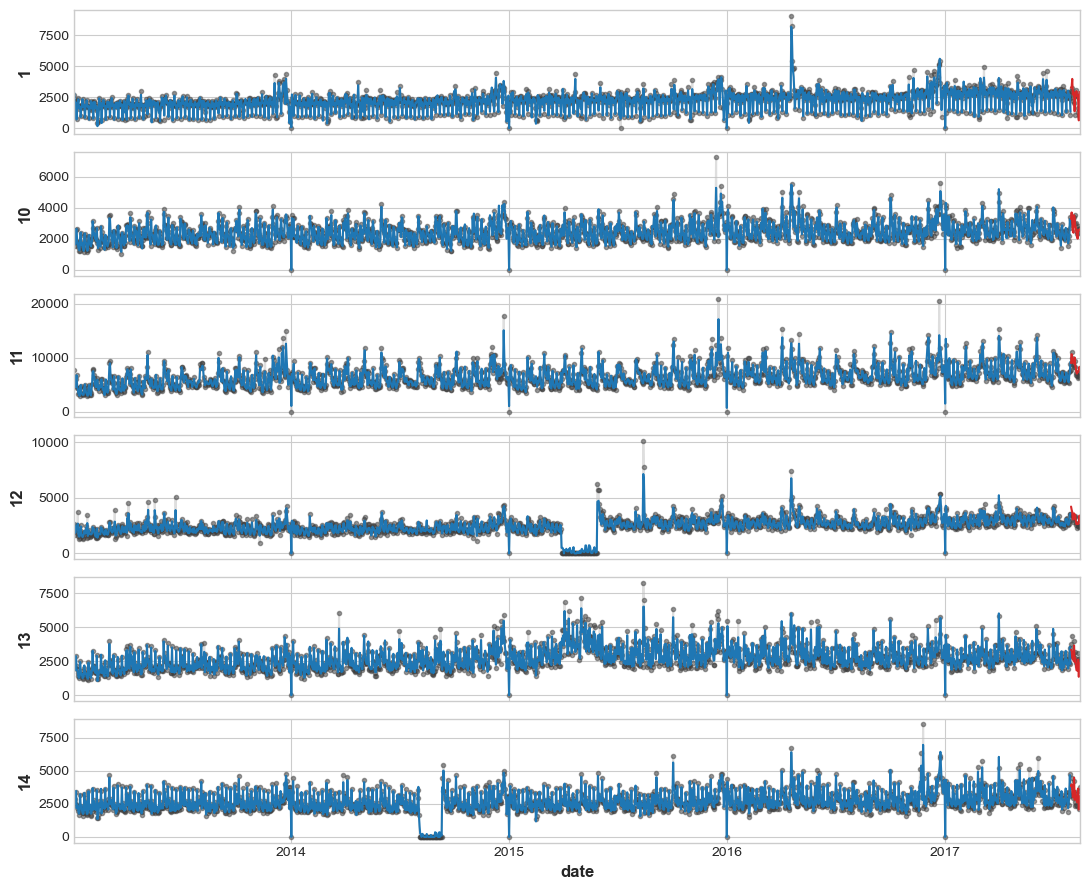

In [88]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=RandomForestRegressor(),
)
display_result(X_1, X_2, y, model)

#### 4.2.2. Stratégie de prévision de plusieurs pas de temps

Dans les sections précédentes, nous avons constaté qu'il existait une dépendance sérielle très forte avec le premier décalage des series temprorelles des ventes. Les données de ventes n'existants pas pour les données de test, il faudrait donc trouver une stratégie pour utiliser des valeurs prédites comme variable. 

Les données d'entrainement se terminent le 08/15/2017, ce qui nous donne l'origine de la prévision. Les données de test contiennent les dates du 16/08/2017 au 31/08/2017, ce qui nous donne l'horizon de la prévision. Il y a un pas de temps entre l'origine et l'horizon, nous avons donc un délai d'un jour.

Autrement dit, nous avons besoin d'une prévision en 16 pas de temps avec un délai d'une pas. Nous pouvons utiliser des décalages en commençant par le décalage 1, et nous faisons la prévision complète des 16 pas de temps en utilisant les variables de la prédiction du premier pas qui est le 16/08/2017.

In [89]:
def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)

In [386]:
# get ts by open date and family
FAMILY = "GROCERY I"
stores_data = data_by_open_date['2013-01-02']
stores_data = stores_data[stores_data.date.isin(train.date)]
stores_data = stores_data[stores_data.family == FAMILY]
stores_data = stores_data.drop(['family'], axis=1)

family_open_date = stores_data.reset_index()[["date", "store_nbr", "sales"]].groupby(
    ["date", "store_nbr"]).sum().reset_index()
family_open_date = (family_open_date[family_open_date["sales"] > 0].groupby("store_nbr")["date"].min()).max()

ts_stores_data = stores_data.reset_index()[["store_nbr", "date", "sales", "onpromotion"]]
ts_stores_data = ts_stores_data.set_index(['store_nbr', 'date']).sort_index()
ts_stores_data = ts_stores_data.unstack(['store_nbr'])
ts_stores_data = ts_stores_data.loc[family_open_date:]
print(ts_stores_data.shape)
ts_stores_data.tail()

(1683, 92)


sales                                                                                                                                                                                                                                                                                                                                                                              onpromotion                                                                                                                                                                                    
store_nbr        1      10      11      12      13      14      15      16      17      18      19       2      23      24      25      26      27       28       3      30      31      32      33      34      35      37      38      39       4       40      41      43      44       45       46       47      48      49       5      50      51      54       6       7       8       9           1  10  11  12  13  14  15  16  17  18  19   2  23  24  25  26  27  28   3  30  31  32  33  34  35  37  38  39   4  40  41  43  44  45  46  47  48  49   5  50  51  54   6   7   8   9
date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2017-08-11 1270.00 2349.00 6551.16 2497.00 2639.00 2987.00 2034.00 2122.00 3957.00 2225.83 3301.00 3574.00 1834.00 3644.00 4433.00 1452.00 4149.00  5148.17 7727.00 1852.00 4205.84 1426.00 2671.00 4473.83 2297.00 2555.00 2918.00 3841.18 2843.00  6948.00 3970.00 4817.77 9979.00 11088.00  9934.00 10297.00 8547.00 7680.00 2864.00 6808.00 5483.00 2823.00 4466.00 3146.00 4318.00 5882.58          24  44  73  48  41  53  51  39  53  51  50  35  29  28  31  29  32  59  36  32  66  40  47  59  44  32  35  65  31  51  35  52  38  40  41  42  37  39  35  34  34  45  38  27  36  65
2017-08-12 1630.00 2629.00 6205.76 2481.00 3105.00 3441.00 2316.00 1777.00 4400.00 2810.62 4661.00 3366.00 1762.00 3629.00 3061.00 1083.00 3540.00  9841.52 7167.00 1904.00 4703.27 1582.00 2886.00 3820.10 2444.00 2496.00 3393.00 4344.18 2876.00 10739.00 3631.00 4362.09 9391.00  9917.00  9218.00  9258.00 8306.00 7030.00 2476.00 6202.00 4249.00 4161.00 4027.00 2851.00 4734.00 6686.11          28  46  59  48  42  50  53  38  52  60  48  33  28  26  30  22  29  57  34  39  69  46  49  56  43  33  33  59  30  60  33  52  39  39  40  40  37  37  31  34  34  49  34  33  34  64
2017-08-13  952.00 2834.00 6471.55 2350.00 1980.00 2140.00 2052.00 2485.00 4899.00 3036.94 2819.00 3735.00 1934.00 3295.00 1962.00 1661.00 5220.00 11002.66 7749.00 1938.00 5742.52 1676.00 3571.00 4523.29 1973.00 1842.00 3448.00 4392.07 3397.00  5364.00 4188.00 6367.10 9811.00 12723.00 10557.00 10110.00 9423.00 7655.00 3141.00 7178.00 5942.00 4739.00 5481.00 2864.00 5050.00 6711.16          19  51  58  46  44  42  53  45  53  60  47  32  23  28  27  26  33  60  36  51  65  47  47  53  37  27  34  63  28  58  33  53  41  38  40  37  38  41  31  37  34  50  35  28  36  62
2017-08-14 2407.00 2625.00 7380.54 2702.00 2547.00 2732.00 2854.00 2354.00 4648.00 2631.50 3200.00 3343.00 2064.00 3952.00 1764.00 1069.00 4155.00  6050.03 7053.00 1966.00 3883.88 1577.00 3026.00 4130.40 1922.00 3315.00 3292.00 5761.38 2750.00  6319.00 2974.00 4840.36 8318.00  9665.00  7570.00  8946.00 6712.00 7366.00 2717.00 6041.00 4227.00 3274.00 4142.00 3872.00 4354.00 5860.79          30  45  58  54  45  46  51  47  54  57  49  36  24  33  31  25  31  56  34  41  61  37  50  61  41  36  37  67  29  57  31  51  39  39  39  40  39  41  32  36  31  

In [387]:
# Target series
y = ts_stores_data.loc[:, 'sales']
y = make_multistep_target(y, steps=16)
y = y.stack().dropna()
print(y.shape)
y.xs(STORE_NBR, level='store_nbr', axis=0, drop_level=False).tail(1)

(76728, 16)


y_step_1  y_step_2  y_step_3  y_step_4  y_step_5  y_step_6  y_step_7  y_step_8  y_step_9  y_step_10  y_step_11  y_step_12  y_step_13  y_step_14  y_step_15  y_step_16
date       store_nbr                                                                                                                                                                       
2017-07-31 44          9934.00  10941.00  11156.00   8419.00   9346.00  12463.00  13248.00   8497.00   8201.00    8062.00    7097.00    9979.00    9391.00    9811.00    8318.00    8123.00

In [384]:
def get_output_target(target):
    output = target.unstack(['store_nbr']).tail(1)
    result = output['y_step_1']
    for i in range(1, 16):
        result = pd.concat([
            result,
            output[f'y_step_{i + 1}'].set_index(output.index.shift(i)),
        ], axis=0)
    return result.stack().rename("y_step_1")


get_output_target(y).xs(STORE_NBR, level='store_nbr', axis=0, drop_level=False)

date        store_nbr
2017-07-31  44           9934.00
2017-08-01  44          10941.00
2017-08-02  44          11156.00
2017-08-03  44           8419.00
2017-08-04  44           9346.00
2017-08-05  44          12463.00
2017-08-06  44          13248.00
2017-08-07  44           8497.00
2017-08-08  44           8201.00
2017-08-09  44           8062.00
2017-08-10  44           7097.00
2017-08-11  44           9979.00
2017-08-12  44           9391.00
2017-08-13  44           9811.00
2017-08-14  44           8318.00
2017-08-15  44           8123.00
Name: y_step_1, dtype: float64

In [388]:
# onpromotion = ts_stores_data.loc[:, 'onpromotion']
# X_promo = pd.concat([
#     make_lags(onpromotion, lags=1, name="onpromotion").stack(),
#     onpromotion.stack().rename('onpromotion'),
#     make_leads(onpromotion, leads=1, name="onpromotion").stack(),
# ], axis=1)
X_promo = ts_stores_data.loc[:, 'onpromotion'].stack().rename('onpromotion')
X_lags = make_lags(ts_stores_data.loc[:, 'sales'], lags=1, name="y").stack()

X = pd.merge(X_lags, X_promo, how="left", left_index=True, right_index=True).dropna()
print(X.shape)
X.xs(STORE_NBR, level='store_nbr', axis=0, drop_level=False).tail(1)

#######################################################
# X_lags = make_lags(y_deseason, lags=1, name="y_deseason").stack()
# 
# onpromotion = ts_stores_data.loc[:, 'onpromotion']
# X_promo = pd.concat([
#     make_lags(onpromotion, lags=1, name="onpromotion").stack(),
#     onpromotion.stack().rename('onpromotion'),
#     make_leads(onpromotion, leads=1, name="onpromotion").stack(),
# ], axis=1)
# X = pd.merge(X_lags, X_promo, how="left", left_index=True, right_index=True)
# X = X.unstack(['store_nbr']).dropna()
# X['year'] = X.index.year.astype(int)
# X["month"] = X.index.month.astype(int)
# X['week_of_year'] = X.index.weekofyear.astype(int)
# X["day_of_week"] = X.index.dayofweek.astype(int)
# X["day_of_year"] = X.index.dayofyear.astype(int)
# 
# X_time = X_time[X.index.min():]
# y = y[X.index.min():]
# y_deseason = y_deseason[X.index.min():]
# print(X.shape)
# print(X_time.shape)
# print(y.shape)
# print(y_deseason.shape)

(77372, 2)


y_lag_1  onpromotion
date       store_nbr                      
2017-08-15 44         8318.00           37

In [396]:
y, X = y.align(X, join='inner', axis=0)
X = X.sort_index()
y = y.sort_index()
print(y.index.get_level_values("date").max())
print(X.index.get_level_values("date").max())
print(y.shape)
print(X.shape)

2017-07-31
2017-07-31
(76682, 16)
(76682, 2)


Créons une instance de modèle pour appliquer la stratégie DirRec à XGBoost et à partir des variables du `2017-07-16`, prédire les 15 jours suivants.

In [410]:
from sklearn.multioutput import RegressorChain

y_train, y_test = y.loc[:"2017-06-30", :], y.loc["2017-07-16", :]
X_train, X_test = X.loc[:"2017-06-30", :], X.loc["2017-07-16", :]

model = RegressorChain(base_estimator=XGBRegressor()).fit(X_train, y_train)

y_pred = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y_train.columns).clip(0.0)
y_test_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y_test.columns).clip(0.0)

print_rmsle(
    get_output_target(y_train),
    get_output_target(y_pred),
    get_output_target(y_test),
    get_output_target(y_test_pred))

In [418]:
get_output_target(y_test_pred).xs(STORE_NBR, level='store_nbr', axis=0, drop_level=False)

date        store_nbr
2017-07-16  44           9949.31
2017-07-17  44          10143.52
2017-07-18  44           8889.84
2017-07-19  44           7917.70
2017-07-20  44           8816.82
2017-07-21  44           9792.96
2017-07-22  44          11572.87
2017-07-23  44          10329.05
2017-07-24  44           9488.13
2017-07-25  44           9370.23
2017-07-26  44           7945.83
2017-07-27  44           8973.32
2017-07-28  44          10708.35
2017-07-29  44          12623.21
2017-07-30  44          11524.97
2017-07-31  44          11750.10
Name: y_step_1, dtype: float64

In [107]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

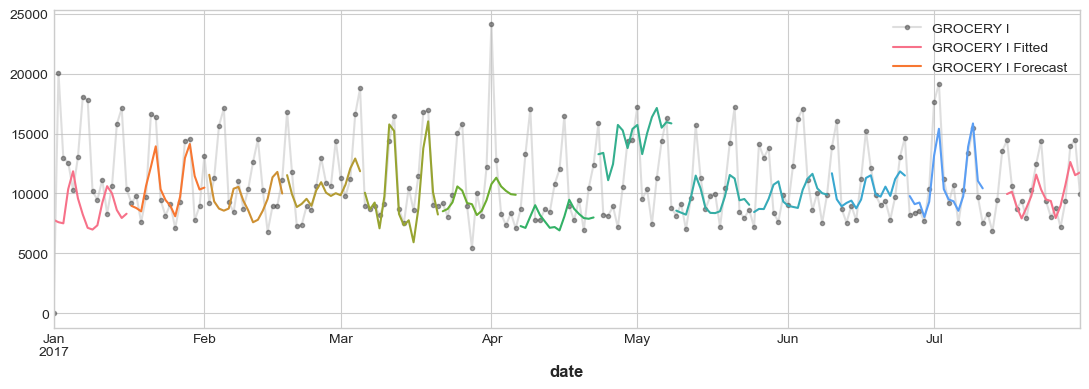

In [420]:
STORE_NBR = '44'
EVERY = 16

y_pred_ = y_pred.xs(STORE_NBR, level='store_nbr', axis=0)
y_test_pred_ = y_test_pred.xs(STORE_NBR, level='store_nbr', axis=0)
y_ = ts_stores_data['sales'].loc[:, STORE_NBR]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.loc['2017-01-01':'2017-07-31'].plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_.loc['2017'], ax=ax, every=EVERY)
ax = plot_multistep(y_test_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Fitted', FAMILY + ' Forecast'])

#### 4.2.3. Modèle optimal

Essayons d'autres combinaisons d'algorithmes de scikit-learn.

In [ ]:
# LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=XGBRegressor(),
)
display_result(X_1, X_2, y, model)

In [ ]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=KNeighborsRegressor(),
)
display_result(X_1, X_2, y, model)

In [ ]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=ExtraTreesRegressor(),
)
display_result(X_1, X_2, y, model)

In [ ]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(fit_intercept=False, alpha=10),
    model_2=MLPRegressor(),
)
display_result(X_1, X_2, y, model)

### 4.3. Modèle finale

In [95]:
df_test = test.set_index(['store_nbr', 'family', 'date']).sort_index()
df_test.head(30)

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
                     2017-08-21  3009798            0
                     2017-08-22  3011580            0
                     2017-08-23  3013362            0
                     2017-08-24  3015144            0
                     2017-08-25  3016926            0
                     2017-08-26  3018708            0
                     2017-08-27  3020490            0
                     2017-08-28  3022272            0
                     2017-08-29  3024054            0
                     2017-08-30  3025836            0
                     2017-08-31  3027618            0
          BABY CARE  2017-08-16  3000889            0
                     2017-08-17  3002671            0
                     2017-08-18  3004453            0
                     2017-08-19  3006235            0
                     2017-08-20  3008017            0
                     2017-08-21  3009799            0
                     2017-08-22  3011581            0
                     2017-08-23  3013363            0
                     2017-08-24  3015145            0
                     2017-08-25  3016927            0
                     2017-08-26  3018709            0
                     2017-08-27  3020491            0
                     2017-08-28  3022273            0
                     2017-08-29  3024055            0

In [96]:
def train_model_by_family(input_data, input_family):
    max_open_date = input_data.reset_index()[["date", "store_nbr", "sales"]].groupby(
        ["date", "store_nbr"]).sum().reset_index()
    max_open_date = (max_open_date[max_open_date["sales"] > 0].groupby("store_nbr")["date"].min()).max()

    input_data_by_store = input_data.reset_index()[["store_nbr", "date", "sales", "onpromotion"]]

    input_data_by_store = input_data_by_store.set_index(['store_nbr', 'date']).sort_index()
    input_data_by_store = input_data_by_store.unstack(['store_nbr'])
    input_data_by_store = input_data_by_store.loc[max_open_date:]

    y_target = input_data_by_store.loc[:, 'sales']
    y_target = y_target[y_target.index.isin(train.date)]
    calendar_fourier = CalendarFourier(freq='W', order=3)
    deterministic_process = DeterministicProcess(
        constant=True,  # dummy feature for bias (y-intercept)
        index=y_target.index,
        order=3,
        seasonal=True,
        drop=True,
        additional_terms=[calendar_fourier],
    )
    x1 = deterministic_process.in_sample()
    x1_test = deterministic_process.out_of_sample(steps=16)

    input_data_by_store = input_data_by_store.drop('sales', axis=1).stack()  #feature
    input_data_by_store = input_data_by_store.reset_index('store_nbr')
    input_data_by_store = pd.get_dummies(input_data_by_store, columns=["store_nbr"])

    x2 = input_data_by_store[input_data_by_store.index.isin(train.date)]
    x2['year'] = x2.index.year.astype(int)
    x2["month"] = x2.index.month.astype(int)
    x2['week_of_year'] = x2.index.weekofyear.astype(int)
    x2["day_of_week"] = x2.index.dayofweek.astype(int)
    x2["day_of_year"] = x2.index.dayofyear.astype(int)

    hybrid_model = BoostedHybrid(
        model_1=Ridge(fit_intercept=False, alpha=10),
        model_2=RandomForestRegressor(),
    )
    hybrid_model.fit(x1, x2, y_target)

    x2_test = input_data_by_store[input_data_by_store.index.isin(test.date)]
    x2_test['year'] = x2_test.index.year.astype(int)
    x2_test["month"] = x2_test.index.month.astype(int)
    x2_test['week_of_year'] = x2_test.index.weekofyear.astype(int)
    x2_test["day_of_week"] = x2_test.index.dayofweek.astype(int)
    x2_test["day_of_year"] = x2_test.index.dayofyear.astype(int)

    y_arg_test = hybrid_model.predict(x1_test, x2_test).clip(0.0)

    y_submit = pd.DataFrame(y_arg_test.stack(['store_nbr']), columns=["sales"])
    y_submit.index.names = ['date', 'store_nbr']
    y_submit = y_submit.reset_index()
    # y_submit = y_submit[~y_submit.store_nbr.isin(non_model_stores_to_exclude)]
    y_submit["family"] = input_family
    y_submit = y_submit.set_index(['store_nbr', 'family', 'date']).sort_index()
    y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
    return y_submit

In [97]:
y_zero = zero_prediction.set_index(['store_nbr', 'family', 'date']).sort_index()
print(y_zero.shape)
y_zero = y_zero.join(df_test.id).reindex(columns=['id', 'sales'])
print(y_zero.shape)
y_zero.head()

(848, 1)
(848, 2)


id  sales
store_nbr family    date                      
1         BABY CARE 2017-08-16  3000889      0
                    2017-08-17  3002671      0
                    2017-08-18  3004453      0
                    2017-08-19  3006235      0
                    2017-08-20  3008017      0

Entrainons les 297 modèles.

In [98]:
y_by_family = y_zero
i = 0
for key, val in data_by_open_date.items():
    for fam in families_list:
        i = i + 1
        ts = val[val.family == fam]
        ts = ts.drop(['family'], axis=1)
        ts = ts[~ts.store_nbr.isin(zero_prediction[zero_prediction.family == fam].store_nbr)]
        if len(ts) > 0:
            print(str(i), "_________________________ family :", fam, "_______________ open_date :", str(key))
            # stores_to_exclude = non_model_stores[key]
            y_results = train_model_by_family(ts, fam)
            y_by_family = pd.concat([y_by_family, y_results])

y_by_family = y_by_family.sort_values('id', ascending=True)
print(y_by_family.shape)
y_by_family.head()

1 _________________________ family : AUTOMOTIVE _______________ open_date : 2013-01-02
2 _________________________ family : BEAUTY _______________ open_date : 2013-01-02
3 _________________________ family : BEVERAGES _______________ open_date : 2013-01-02
4 _________________________ family : BOOKS _______________ open_date : 2013-01-02
5 _________________________ family : BREAD/BAKERY _______________ open_date : 2013-01-02
6 _________________________ family : CELEBRATION _______________ open_date : 2013-01-02
7 _________________________ family : CLEANING _______________ open_date : 2013-01-02
8 _________________________ family : DAIRY _______________ open_date : 2013-01-02
9 _________________________ family : DELI _______________ open_date : 2013-01-02
10 _________________________ family : EGGS _______________ open_date : 2013-01-02
11 _________________________ family : FROZEN FOODS _______________ open_date : 2013-01-02
12 _________________________ family : GROCERY I _______________ o

id   sales
store_nbr family     date                       
1         AUTOMOTIVE 2017-08-16  3000888    4.02
          BABY CARE  2017-08-16  3000889    0.00
          BEAUTY     2017-08-16  3000890    5.38
          BEVERAGES  2017-08-16  3000891 2705.03
          BOOKS      2017-08-16  3000892    0.12

In [99]:
y_by_family.to_csv('submission.csv', index=False)